#1. Introduction

This colab provides the code for Crossvalidation to asses the performance of the BERT large cased model. This version is **stable**. The files you will need for this colab are "PETv1.1-entities.jsonl" and "complete_combined_leschneiderdata_NER.jsonl". The paths of which you need to specify.

##1.1 Preliminary Code

The code below provides the necesary libraries, paths to the input data and initial variable setups.

In [ ]:
#@title Importing and setting variables
import torch
import json
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import random
import copy

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


drive.mount('/content/drive/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting up the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
# Constants, can be changed for model optimisation
MAX_LEN = 128  # Or any max length suited to your data
BATCH_SIZE = 8
EPOCHS = 7

In [ ]:
#@title Printing Model Output Code
def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


def print_token_true_labels_per_sentence_excluding_special_tokens(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Move model to the correct device and set to evaluation mode

    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop after reaching the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the correct device

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
            true_labels = [reverse_label_map[label_id] for label_id in true_label_ids]

            # Filter tokens and labels to exclude special tokens and corresponding labels
            filtered_tokens_and_labels = [
                (token, label) for token, label, mask in zip(tokens, true_labels, attention_mask)
                if mask == 1 and token not in tokenizer.all_special_tokens
            ]

            filtered_tokens = [token for token, _ in filtered_tokens_and_labels]
            filtered_true_labels = [label for _, label in filtered_tokens_and_labels]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens:")
            print(filtered_tokens)
            print("True Labels:")
            print(filtered_true_labels)
            print("\n")

            samples_printed += 1

# Ensure you have your val_dataloader, model, tokenizer, and reverse_label_map properly defined before calling this function.

def output_predictions_to_excel(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5, file_name='output.xlsx'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Ensure the model is in evaluation mode and moved to the right device
    samples_printed = 0

    # Prepare DataFrame
    columns = ['Token', 'True Label', 'Predicted Label']
    data = []

    for batch in val_dataloader:
        #if samples_printed >= num_samples:
            #break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            #if samples_printed >= num_samples:
                #break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            # Append each token and its labels to the data list
            data.extend([(token, true, pred) for token, true, pred in zip(tokens, true_labels, pred_labels)])

            samples_printed += 1

    # Create DataFrame and write to Excel
    file_path = f"/content/drive/MyDrive/THESIS/CODING/BERT outputs/BERT predictions/{file_name}"
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(file_path, index=False)

    print(f"Output written to {file_path}")

# Ensure your model, tokenizer, and dataloader are properly initialized before calling this function.


In [ ]:
#@title Initialization of necessary functions for crossvalidation and training of BERT

#This function is grouping and loading data per doc-id such that they are processed per doc-id. The function expects a path to a .json file
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)
            #print(entry)
    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

#For the calculation of accuracy metrics
def calculate_f1(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        check_true, check_pred = set(), set()
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Flatten labels and predictions
            batch_labels = batch['labels'].detach().cpu().numpy()
            batch_predictions = predictions.detach().cpu().numpy()

            true_labels.extend(batch_labels.flatten())
            pred_labels.extend(batch_predictions.flatten())
            check_true.update(true_labels)
            check_pred.update(pred_labels)


    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return precision, recall, f1


#This class tokenizes the sentences and their words according to the predefined tokenizer for BERT. Also maps the labels to their integer number values.
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, label_map):
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

#This function employs a BERT model training where no early stopping is used
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Directory where you want to save your model checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    #Initialize score
    best_f1_score = 0.0

    #In order to plot the validation and training losses to check for overfitting
    training_losses = []
    validation_losses = []

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        print("Training...")
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

            if step % 100 == 0 or step == len(train_dataloader) - 1:
                precision, recall, f1 = calculate_f1(model, val_dataloader, device)
                print(f"Step {step}, Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.4f}\n')

        training_losses.append(avg_train_loss)

        # In each epoch we validate the current model so to get the Validation Loss for plotting.
        val_metrics = evaluate_model(model, val_dataloader, label_map)
        validation_losses.append(val_metrics['avg_val_loss'])

    return model, training_losses, validation_losses

#This function employs a BERT model training where early stopping is used
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, patience, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_f1_score = 0.0
    patience_counter = 0

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        precision, recall, f1 = calculate_f1(model, val_dataloader, device)
        print(f"Epoch {epoch_i + 1}, Validation Precision: {precision}, Recall: {recall}, F1: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Validation F1 Score improved. Saving model checkpoint.")
        else:
            patience_counter += 1
            print("Validation F1 Score did not improve.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch_i + 1} completed.\n')

    # Load the best model after training ends
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))



In [ ]:
#@title convert_IOB2_to_chunks
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_chunk:  # End current chunk before starting 'O' chunk
                    chunks.append((current_type, current_chunk))
                current_type = 'O'
                current_chunk = [idx, idx]  # Start a new 'O' chunk immediately


            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

In [ ]:
#@title Evaluation helper functions
def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)


    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)

    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support,
            "TP": tp,
            "FP": fp,
            "FN": fn
        }

    return metrics_per_label

def calculate_macro_averaged_f1(metrics_per_label):
    f1_scores = [metrics['F1'] for metrics in metrics_per_label.values()]
    macro_averaged_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return macro_averaged_f1

def calculate_micro_f1(metrics_per_label):
    # Initialize counters for total TP, FP, and FN
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the TP, FP, and FN for the current label
        tp = metrics["TP"]
        fp = metrics["FP"]
        fn = metrics["FN"]

        # Accumulate the total TP, FP, and FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate micro precision and recall
    if (total_tp + total_fp) > 0:
        micro_precision = total_tp / (total_tp + total_fp)
    else:
        micro_precision = 0

    if (total_tp + total_fn) > 0:
        micro_recall = total_tp / (total_tp + total_fn)
    else:
        micro_recall = 0

    # Calculate micro F1 score
    if (micro_precision + micro_recall) > 0:
        micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1 = 0

    return micro_f1

def calculate_weighted_f1(metrics_per_label):

    # Initialize variables for the sum of weighted F1 scores and the total support
    weighted_f1_sum = 0
    total_support = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the F1 score and support for the current label
        f1_score = metrics["F1"]
        support = metrics["Support"]

        # Add the product of the current label's F1 score and its support to the sum of weighted F1 scores
        weighted_f1_sum += f1_score * support

        # Add the current label's support to the total support
        total_support += support

    # Calculate the overall weighted F1 score by dividing the sum of weighted F1 scores by the total support
    if total_support > 0:
        overall_weighted_f1 = weighted_f1_sum / total_support
    else:
        overall_weighted_f1 = 0

    return overall_weighted_f1

def convert_int_2string(nested_label_list, reverse_label_map):

    all_chunks = []

    for sentence in nested_label_list:
        chunks = []
        current_chunk = []
        current_label = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if current_label is None or current_label != label:
                if current_chunk:
                    chunks.append((current_label, current_chunk))
                current_label = label
                current_chunk = [idx, idx]
            else:
                current_chunk[1] = idx

        if current_chunk:
            chunks.append((current_label, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

def get_sorted_labels(val_metrics):

    pairs = []
    non_paired_labels = []

    for label in sorted(val_metrics['detailed_metrics'].keys()):  # Sort keys to maintain alphabetical order
        if label.startswith("B-"):
            corresponding_i_label = f"I-{label[2:]}"
            if corresponding_i_label in val_metrics['detailed_metrics']:
                pairs.append((label, corresponding_i_label))
            else:
                non_paired_labels.append(label)  # Add B- label if I- counterpart not found
        elif not label.startswith("I-"):  # This will automatically handle 'O' and other non B-/I- labels
            non_paired_labels.append(label)

    # Flatten the sorted pairs
    sorted_labels = [label for pair in pairs for label in pair]

    # Add non-paired labels at the end
    sorted_labels.extend(non_paired_labels)

    return sorted_labels



The next functions are used for model evaluation

In [ ]:
#@title Main Evaluation function & Plotting
def evaluate_model(model, val_dataloader, label_map):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())

        nb_eval_steps += 1

    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    #true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    #pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    true_labels_entities = convert_int_2string(true_labels, reverse_label_map)
    pred_labels_entities = convert_int_2string(pred_labels, reverse_label_map)
    #print(f"TRUE LABELS {true_labels_entities}")
    #print(f"PRED LABELS {pred_labels_entities}")


    #We calculate metrics per label
    #label_metrics = compare_entities(true_labels_entities, pred_labels_entities)
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)

    #The averaged F1 where you treat each class equally without considering the labels frequency.
    macro_averaged_f1 = calculate_macro_averaged_f1(label_metrics)
    print(f"Macro-Averaged F1 Score: {macro_averaged_f1:.4f}\n")

    micro_average_f1 = calculate_micro_f1(label_metrics)
    print(f"Micro-Averaged F1 Score: {micro_average_f1:.4f}\n")

    #The weighted F1 accounts for the frequency in which a label occurs
    weighted_average_f1 = calculate_weighted_f1(label_metrics)
    print(f"Weigthed-Averaged F1 Score: {weighted_average_f1:.4f}\n")

    # Calculate average validation loss
    avg_val_loss = eval_loss / nb_eval_steps

    # Print average validation loss
    #print(f"Validation Loss: {avg_val_loss}\n")

    detailed_metrics = {}
    # Print metrics per label and aggregate them into detailed_metrics dictionary
    for label, metrics in label_metrics.items():
      precision = metrics['Precision']
      recall = metrics['Recall']
      f1 = metrics['F1']
      support = metrics['Support']

      detailed_metrics[label] = {
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'support': support}

    # Return a dictionary with detailed metrics per label, weighted F1 score, and average validation loss
    return {
        'detailed_metrics': detailed_metrics,
        'macro_averaged_f1': macro_averaged_f1,
        'micro_averaged_f1': micro_average_f1,
        'weighted_average_f1': weighted_average_f1,
        'avg_val_loss': avg_val_loss
    }



#This function returns a confusion matrix between the true and predicted labels
def plot_confusion_matrix(true_labels, pred_labels, reverse_label_map):

    # Convert label IDs back to their string representations
    true_labels_str = [reverse_label_map[label] for label in true_labels]
    pred_labels_str = [reverse_label_map[label] for label in pred_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str, labels=list(reverse_label_map.values()))

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_map.values()), yticklabels=list(reverse_label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#This plot shows the overfitting of our model
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle="--")

    #Find the minimum validation loss and its corresponding epoch
    min_val_loss = min(validation_losses)
    min_val_loss_epoch = validation_losses.index(min_val_loss) + 1  # Adding 1 because epochs start at 1

    # Draw a horizontal line at the minimum validation loss
    plt.axhline(y=min_val_loss, color='r', linestyle='--', label=f'Min Validation Loss: {min_val_loss:.4f}')

    # Draw a vertical line at the epoch of the minimum validation loss
    plt.axvline(x=min_val_loss_epoch, color='g', linestyle='--', label=f'Epoch: {min_val_loss_epoch}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(visible=True)
    plt.show()



Below is the core function for the crossvalidation. **To adjust the model**, uncomment and comment the "model" from line 61.

In [ ]:
#@title Crossvalidation Function
#This code performs the cross_validation and trains the model n times.
def grouped_k_fold_cross_validation(data, splits: int(), batch_size, EPOCHS, label_map, learning_rate):

    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = set(item['document name'] for item in data)
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = [doc_to_id[item['document name']] for item in data]

    # Step 2: Initializing GroupKFold Crossvalidation
    gkf = GroupKFold(n_splits=splits)

    #In order to compute an aggregate result through all folds at the end we need to keep a list.
    all_fold_results = []
    # Initialize a dictionary to accumulate F1 scores for each label across folds
    label_f1_scores = {label: [] for label in label_map.keys()}
    label_P_scores = {label: [] for label in label_map.keys()}
    label_R_scores = {label: [] for label in label_map.keys()}

    # To chose the best performing model
    models_and_metrics = {}

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=group_ids)):
        print(f"Fold {fold+1}")

        #We split the entire dataset based on train_idx and val_idx given by the GroupKFold module.
        #It ensures no two identical groups are presented as a validation set twice.
        train_subset = Subset(data, indices=train_idx)
        val_subset = Subset(data, indices=val_idx)

        # Instantiate the dataset and dataloader for training
        train_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in train_subset],
            labels=[entry['ner-tags'] for entry in train_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        # Instantiate the dataset and dataloader for validation
        val_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in val_subset],
            labels=[entry['ner-tags'] for entry in val_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        #Initialize the DataLoader objects
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        #loading the desired model: each fold we need start fresh
        model = BertForTokenClassification.from_pretrained('bert-large-cased', num_labels=NUM_LABELS)

        # Fine-tuning setup, can be changed for model optimisation
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Using funtion defined above to train the model and obtain the losses for plotting at the same time
        model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints')
        plot_losses(training_losses,validation_losses)

        #Evaluating the model in this fold
        val_metrics = evaluate_model(model, val_loader, label_map)

        all_fold_results.append(val_metrics)

        models_and_metrics[fold] = {
        "model": model,
        "val_metrics": val_metrics}

        # Open a file for output
        header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
        row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
        print(header)

        # Call the function to get the sorted labels
        sorted_labels = get_sorted_labels(val_metrics)

        for label in sorted_labels:
            metrics = val_metrics['detailed_metrics'][label]
            print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1']), "{:.0f}".format(metrics['support'])))
            label_f1_scores[label].append(metrics['f1'])
            label_P_scores[label].append(metrics['precision'])
            label_R_scores[label].append(metrics['recall'])

        print("SUMMARY FOLD: \n")
        print(f"Macro Averaged F1 Score for fold {fold+1}: {val_metrics['macro_averaged_f1']:.4f}\n")
        print(f"Micro Averaged F1 Score for fold {fold+1}: {val_metrics['micro_averaged_f1']:.4f}\n")
        print(f"Weighted Averaged F1 Score for fold {fold+1}: {val_metrics['weighted_average_f1']:.4f}\n")

        #output_predictions_to_excel(val_loader, model, tokenizer, reverse_label_map, num_samples=5, file_name=f'output_fold{fold}.xlsx')
        #print_token_true_labels_per_sentence(val_loader, model, tokenizer, reverse_label_map, num_samples=2)
        #break

    # Save the best model
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["val_metrics"]["macro_averaged_f1"])

    best_model = models_and_metrics[best_fold]["model"]
    best_model_metrics = models_and_metrics[best_fold]["val_metrics"]

    # Initialize a variable to accumulate weighted F1 scores from each fold
    total_macro_f1 = 0
    total_micro_f1 = 0
    total_weighted_f1 = 0

    # Assuming you're still appending the results of evaluate_model to all_fold_results
    for results in all_fold_results:
        total_macro_f1 += results['macro_averaged_f1']
        total_micro_f1 += results['micro_averaged_f1']
        total_weighted_f1 += results['weighted_average_f1']

    # Calculate the average weighted F1 score across all folds
    print("---------------------------------------")
    print("\nTraining succesfully finished!\n")
    print("---------------------------------------\n")
    print("---------------------------------------")
    print(f"Best fold was fold {best_fold}\n")
    print("---------------------------------------\n")
    average_macro_f1 = total_macro_f1 / len(all_fold_results)
    average_micro_f1 = total_micro_f1 / len(all_fold_results)
    average_weighted_f1 = total_weighted_f1 / len(all_fold_results)
    print(f"Average Macro F1 Score Across All Folds: {average_macro_f1:.4f}")
    print(f"Average Micro F1 Score Across All Folds: {average_micro_f1:.4f}")
    print(f"Average Weighted F1 Score Across All Folds: {average_weighted_f1:.4f}")

    # Calculate and print average F1 scores, precision, and recall for each label across all folds
    row_format = "{:<35} {:<10} {:<10} {:<10}\n"
    print("Average Metrics per Label:\n")
    print(row_format.format("Label", "Precision", "Recall", "F1"))
    for label in label_f1_scores.keys():
        try:
            average_f1 = sum(label_f1_scores[label]) / len(label_f1_scores[label])
            average_precision = sum(label_P_scores[label]) / len(label_P_scores[label])
            average_recall = sum(label_R_scores[label]) / len(label_R_scores[label])
            print(row_format.format(label, "{:.4f}".format(average_precision), "{:.4f}".format(average_recall), "{:.4f}".format(average_f1)))
        except ZeroDivisionError:
            print(f"Zero division error for label {label}")

    return best_model, average_macro_f1, average_micro_f1, average_weighted_f1, label_f1_scores


Now that all functions have been initialized we can start calling them.

##1.2 Data Loading

First we need to load the data, since our combined data is in two seperate files we need to merge them first. Then, we need to tokenize (which happens in the groupfold function) and prepare the data so the model can understand it.

In [ ]:
#setting up the input data and merging them
#adjust according to dataset location
try:
  PET_Folder = '/content/drive/MyDrive/THESIS/DATA/PET/actual PET data from Patrizio Bellan/PETv1.1-entities.jsonl'
  LESCHNEIDER_Folder = '/content/drive/MyDrive/THESIS/DATA/LESCHNEIDER DATA/Documents/FORMATTED_DATA_ELEMENTS/complete_combined_leschneiderdata_NER.jsonl'

  # Load and group data from both files calling on a function above
  grouped_data_1 = load_and_group_ner_data(PET_Folder)
  grouped_data_2 = load_and_group_ner_data(LESCHNEIDER_Folder)

  # Append the contents of the second list to the first
  unflattened_data = grouped_data_1 + grouped_data_2 #Combined data

  #Because the data is grouped according to doc_name, the unflattened_data is a list that contains lists. By unpacking we create a list containing not lists but the actual documents.
  input_data = [item for group in unflattened_data for item in group] #Now input_data containts all the sentences.
  if input_data:
    print("Data Loaded")
    print(f"sample data: {input_data}")
except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")



Data Loaded
sample data: [{'document name': 'doc-10.1', 'sentence-ID': 0, 'tokens': ['The', 'MPON', 'sents', 'the', 'dismissal', 'to', 'the', 'MPOO', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Actor', 'I-Actor', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 1, 'tokens': ['The', 'MPOO', 'reviews', 'the', 'dismissal', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 2, 'tokens': ['The', 'MPOO', 'opposes', 'the', 'dismissal', 'of', 'MPON', 'or', 'the', 'MPOO', 'confirmes', 'the', 'dismissal', 'of', 'the', 'MPON', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'B-XOR Gateway', 'B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O']}, {'document name': 'doc-10.12', 'sentence-ID': 0, 'tokens': ['The', 'EC', 'tells', 'the', 'INQ', 'about', 'th

#2 Model Training & Learning Rate Evaluation

Now we will train the model using Grouped K Crossvalidation for each Learning Rate. Make sure you ran all cells before. **This will take a long time** depending on your configuration and computing power. Here we evaluate the learning rate, we conclude that a learning rate of 5e-5performs best together with an epoch of 5.


---------------------------------------
Learning Rate: 2e-05
---------------------------------------

Fold 1


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6449, Precision: 0.8483, Recall: 0.6428, F1: 0.7303
Step 50, Loss: 0.1907, Precision: 0.9266, Recall: 0.9416, F1: 0.9315
Average training loss: 0.4482

Macro-Averaged F1 Score: 0.1848

Micro-Averaged F1 Score: 0.4145

Weigthed-Averaged F1 Score: 0.4012

Epoch 2/7
Training...
Step 0, Loss: 0.1957, Precision: 0.9276, Recall: 0.9424, F1: 0.9325
Step 50, Loss: 0.1054, Precision: 0.9494, Recall: 0.9585, F1: 0.9523
Average training loss: 0.1636

Macro-Averaged F1 Score: 0.3153

Micro-Averaged F1 Score: 0.6009

Weigthed-Averaged F1 Score: 0.5778

Epoch 3/7
Training...
Step 0, Loss: 0.1263, Precision: 0.9485, Recall: 0.9587, F1: 0.9523
Step 50, Loss: 0.1415, Precision: 0.9540, Recall: 0.9638, F1: 0.9570
Average training loss: 0.0978

Macro-Averaged F1 Score: 0.3901

Micro-Averaged F1 Score: 0.6573

Weigthed-Averaged F1 Score: 0.6358

Epoch 4/7
Training...
Step 0, Loss: 0.0690, Precision: 0.9550, Recall: 0.9637, F1: 0.9574
Step 50, Loss: 0.0310, Precision: 

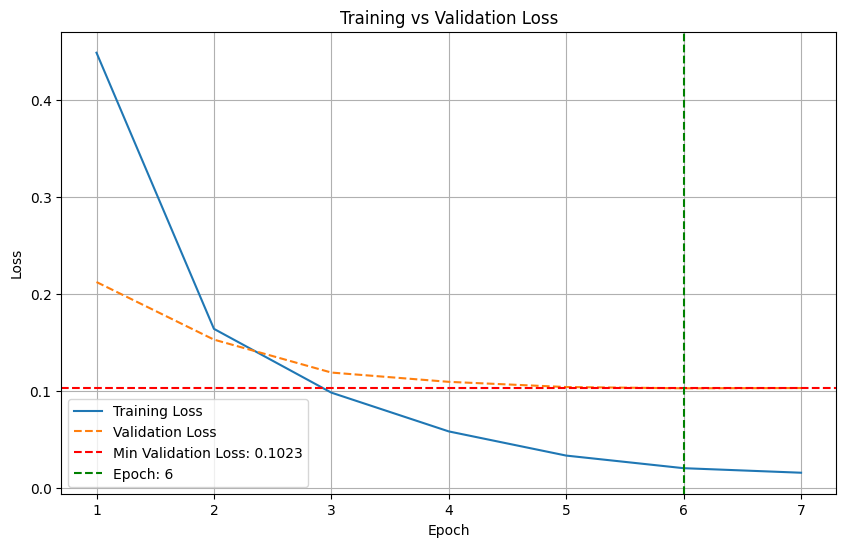

Macro-Averaged F1 Score: 0.5008

Micro-Averaged F1 Score: 0.6998

Weigthed-Averaged F1 Score: 0.6985

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8837     0.9048     0.8941     126       

I-Activity                          0.7500     0.2500     0.3750     12        

B-Activity Data                     0.7833     0.8545     0.8174     110       

I-Activity Data                     0.4847     0.7670     0.5940     103       

B-Actor                             0.8857     0.9029     0.8942     103       

I-Actor                             0.6733     0.8193     0.7391     83        

B-Condition Specification           0.8571     0.5000     0.6316     12        

I-Condition Specification           0.5455     0.5000     0.5217     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9190, Precision: 0.8328, Recall: 0.3628, F1: 0.5021
Step 50, Loss: 0.1807, Precision: 0.8960, Recall: 0.9205, F1: 0.9018
Average training loss: 0.5150

Macro-Averaged F1 Score: 0.0750

Micro-Averaged F1 Score: 0.2475

Weigthed-Averaged F1 Score: 0.2068

Epoch 2/7
Training...
Step 0, Loss: 0.2211, Precision: 0.8912, Recall: 0.9210, F1: 0.9001
Step 50, Loss: 0.2025, Precision: 0.9368, Recall: 0.9508, F1: 0.9415
Average training loss: 0.2054

Macro-Averaged F1 Score: 0.2626

Micro-Averaged F1 Score: 0.5161

Weigthed-Averaged F1 Score: 0.5076

Epoch 3/7
Training...
Step 0, Loss: 0.2253, Precision: 0.9422, Recall: 0.9538, F1: 0.9470
Step 50, Loss: 0.1460, Precision: 0.9527, Recall: 0.9630, F1: 0.9576
Average training loss: 0.1204

Macro-Averaged F1 Score: 0.3264

Micro-Averaged F1 Score: 0.6323

Weigthed-Averaged F1 Score: 0.6218

Epoch 4/7
Training...
Step 0, Loss: 0.0749, Precision: 0.9532, Recall: 0.9633, F1: 0.9580
Step 50, Loss: 0.0597, Precision: 

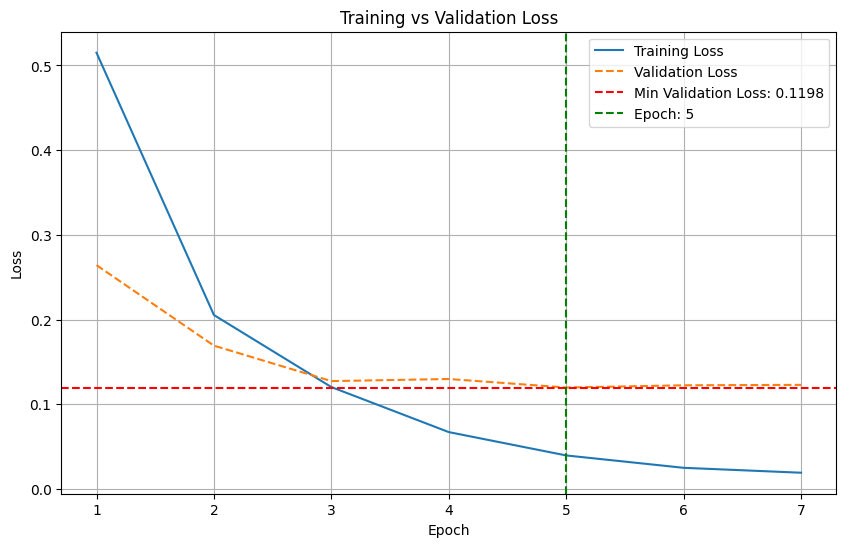

Macro-Averaged F1 Score: 0.4266

Micro-Averaged F1 Score: 0.6803

Weigthed-Averaged F1 Score: 0.6741

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2857     0.4444     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8583     0.8240     0.8408     125       

I-Activity                          1.0000     0.0909     0.1667     11        

B-Activity Data                     0.7581     0.7833     0.7705     120       

I-Activity Data                     0.5333     0.7080     0.6084     113       

B-Actor                             0.7500     0.7568     0.7534     111       

I-Actor                             0.5739     0.6947     0.6286     95        

B-Condition Specification           0.5833     0.4375     0.5000     16        

I-Condition Specification           0.1471     0.3125     0.2000     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7884, Precision: 0.8473, Recall: 0.5659, F1: 0.6775
Step 50, Loss: 0.2107, Precision: 0.9221, Recall: 0.9358, F1: 0.9258
Average training loss: 0.4821

Macro-Averaged F1 Score: 0.2079

Micro-Averaged F1 Score: 0.3728

Weigthed-Averaged F1 Score: 0.3734

Epoch 2/7
Training...
Step 0, Loss: 0.1771, Precision: 0.9171, Recall: 0.9362, F1: 0.9250
Step 50, Loss: 0.1150, Precision: 0.9400, Recall: 0.9533, F1: 0.9462
Average training loss: 0.1658

Macro-Averaged F1 Score: 0.2948

Micro-Averaged F1 Score: 0.5258

Weigthed-Averaged F1 Score: 0.5242

Epoch 3/7
Training...
Step 0, Loss: 0.0822, Precision: 0.9410, Recall: 0.9537, F1: 0.9470
Step 50, Loss: 0.1637, Precision: 0.9527, Recall: 0.9622, F1: 0.9565
Average training loss: 0.0980

Macro-Averaged F1 Score: 0.3751

Micro-Averaged F1 Score: 0.6245

Weigthed-Averaged F1 Score: 0.6143

Epoch 4/7
Training...
Step 0, Loss: 0.0657, Precision: 0.9601, Recall: 0.9625, F1: 0.9573
Step 50, Loss: 0.0431, Precision: 

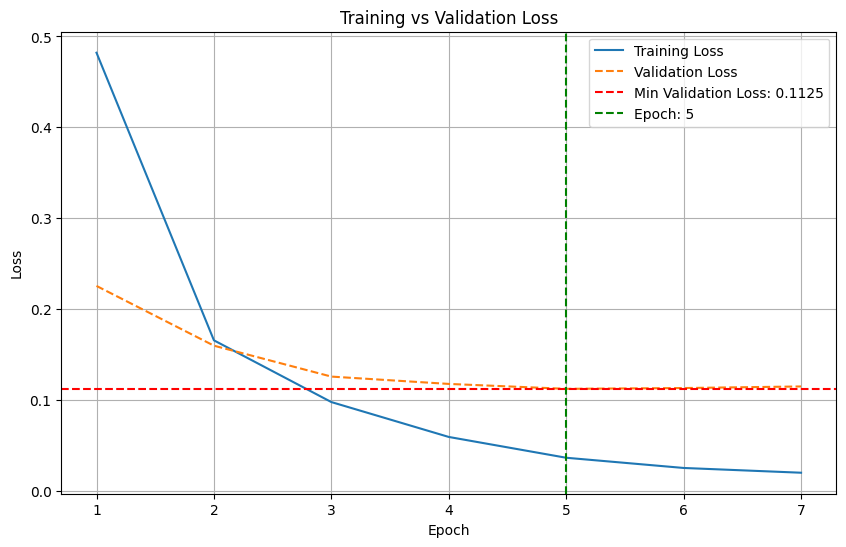

Macro-Averaged F1 Score: 0.4850

Micro-Averaged F1 Score: 0.6767

Weigthed-Averaged F1 Score: 0.6776

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     9         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8130     0.8547     0.8333     117       

I-Activity                          1.0000     0.4444     0.6154     9         

B-Activity Data                     0.8585     0.8349     0.8465     109       

I-Activity Data                     0.4697     0.6458     0.5439     96        

B-Actor                             0.8300     0.8469     0.8384     98        

I-Actor                             0.6471     0.7857     0.7097     84        

B-Condition Specification           0.8421     0.6957     0.7619     23        

I-Condition Specification           0.4839     0.6522     0.5556     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7909, Precision: 0.8124, Recall: 0.5582, F1: 0.6613
Step 50, Loss: 0.2477, Precision: 0.9209, Recall: 0.9396, F1: 0.9297
Average training loss: 0.4897

Macro-Averaged F1 Score: 0.2277

Micro-Averaged F1 Score: 0.4638

Weigthed-Averaged F1 Score: 0.4586

Epoch 2/7
Training...
Step 0, Loss: 0.1662, Precision: 0.9195, Recall: 0.9397, F1: 0.9291
Step 50, Loss: 0.0860, Precision: 0.9402, Recall: 0.9558, F1: 0.9457
Average training loss: 0.1711

Macro-Averaged F1 Score: 0.3423

Micro-Averaged F1 Score: 0.6273

Weigthed-Averaged F1 Score: 0.6106

Epoch 3/7
Training...
Step 0, Loss: 0.1561, Precision: 0.9452, Recall: 0.9579, F1: 0.9488
Step 50, Loss: 0.0613, Precision: 0.9625, Recall: 0.9686, F1: 0.9646
Average training loss: 0.1059

Macro-Averaged F1 Score: 0.4100

Micro-Averaged F1 Score: 0.7178

Weigthed-Averaged F1 Score: 0.7073

Epoch 4/7
Training...
Step 0, Loss: 0.0753, Precision: 0.9623, Recall: 0.9683, F1: 0.9645
Step 50, Loss: 0.0460, Precision: 

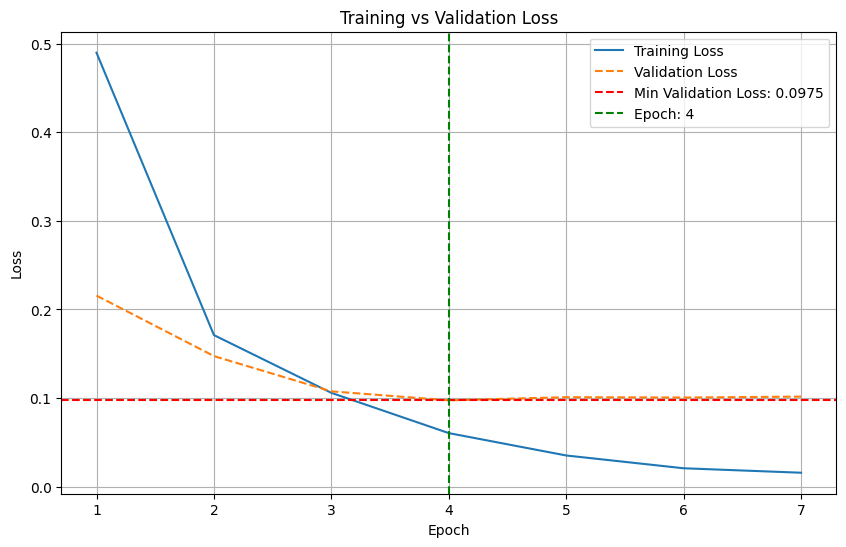

Macro-Averaged F1 Score: 0.5640

Micro-Averaged F1 Score: 0.7564

Weigthed-Averaged F1 Score: 0.7598

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8705     0.9167     0.8930     132       

I-Activity                          0.7500     0.4286     0.5455     7         

B-Activity Data                     0.8060     0.8852     0.8438     122       

I-Activity Data                     0.5870     0.7500     0.6585     108       

B-Actor                             0.8923     0.8855     0.8889     131       

I-Actor                             0.8136     0.8889     0.8496     108       

B-Condition Specification           0.6667     0.4762     0.5556     21        

I-Condition Specification           0.2917     0.3684     0.3256     19        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6497, Precision: 0.8783, Recall: 0.6808, F1: 0.7650
Step 50, Loss: 0.2124, Precision: 0.8974, Recall: 0.9336, F1: 0.9133
Average training loss: 0.4576

Macro-Averaged F1 Score: 0.1399

Micro-Averaged F1 Score: 0.3075

Weigthed-Averaged F1 Score: 0.2787

Epoch 2/7
Training...
Step 0, Loss: 0.2051, Precision: 0.8959, Recall: 0.9325, F1: 0.9112
Step 50, Loss: 0.1403, Precision: 0.9353, Recall: 0.9496, F1: 0.9389
Average training loss: 0.1926

Macro-Averaged F1 Score: 0.2532

Micro-Averaged F1 Score: 0.4694

Weigthed-Averaged F1 Score: 0.4507

Epoch 3/7
Training...
Step 0, Loss: 0.1674, Precision: 0.9386, Recall: 0.9515, F1: 0.9420
Step 50, Loss: 0.1707, Precision: 0.9507, Recall: 0.9596, F1: 0.9544
Average training loss: 0.1373

Macro-Averaged F1 Score: 0.3100

Micro-Averaged F1 Score: 0.5835

Weigthed-Averaged F1 Score: 0.5654

Epoch 4/7
Training...
Step 0, Loss: 0.1128, Precision: 0.9507, Recall: 0.9596, F1: 0.9545
Step 50, Loss: 0.0628, Precision: 

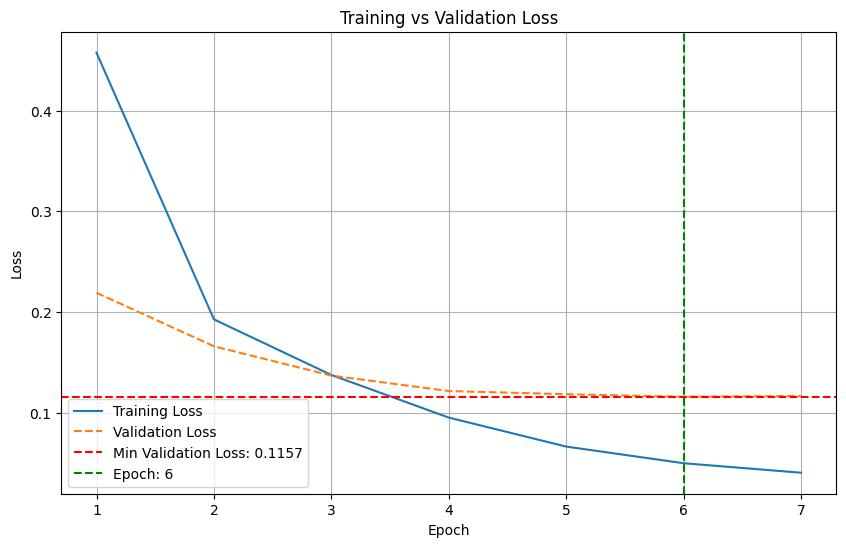

Macro-Averaged F1 Score: 0.4285

Micro-Averaged F1 Score: 0.6603

Weigthed-Averaged F1 Score: 0.6604

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     11        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7308     0.8407     0.7819     113       

I-Activity                          0.0000     0.0000     0.0000     5         

B-Activity Data                     0.7273     0.7477     0.7373     107       

I-Activity Data                     0.4385     0.6064     0.5089     94        

B-Actor                             0.8571     0.9091     0.8824     99        

I-Actor                             0.7778     0.8750     0.8235     88        

B-Condition Specification           0.7059     0.4615     0.5581     26        

I-Condition Specification           0.3448     0.4000     0.3704     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6967, Precision: 0.8437, Recall: 0.8107, F1: 0.8262
Step 50, Loss: 0.2375, Precision: 0.9281, Recall: 0.9409, F1: 0.9290
Average training loss: 0.4060

Macro-Averaged F1 Score: 0.1742

Micro-Averaged F1 Score: 0.4102

Weigthed-Averaged F1 Score: 0.3848

Epoch 2/7
Training...
Step 0, Loss: 0.2007, Precision: 0.9273, Recall: 0.9419, F1: 0.9303
Step 50, Loss: 0.1102, Precision: 0.9368, Recall: 0.9540, F1: 0.9428
Average training loss: 0.1533

Macro-Averaged F1 Score: 0.2901

Micro-Averaged F1 Score: 0.5377

Weigthed-Averaged F1 Score: 0.5193

Epoch 3/7
Training...
Step 0, Loss: 0.1334, Precision: 0.9392, Recall: 0.9563, F1: 0.9459
Step 50, Loss: 0.0685, Precision: 0.9624, Recall: 0.9656, F1: 0.9605
Average training loss: 0.0869

Macro-Averaged F1 Score: 0.4389

Micro-Averaged F1 Score: 0.6630

Weigthed-Averaged F1 Score: 0.6505

Epoch 4/7
Training...
Step 0, Loss: 0.0690, Precision: 0.9623, Recall: 0.9655, F1: 0.9604
Step 50, Loss: 0.0358, Precision: 

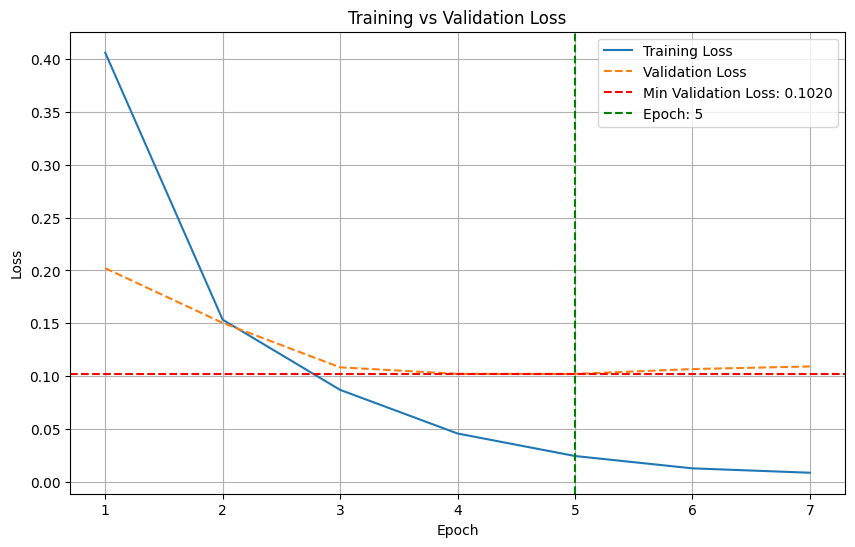

Macro-Averaged F1 Score: 0.5976

Micro-Averaged F1 Score: 0.7410

Weigthed-Averaged F1 Score: 0.7398

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.7500     0.4286     0.5455     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8992     0.9206     0.9098     126       

I-Activity                          0.8750     0.5833     0.7000     12        

B-Activity Data                     0.8348     0.8727     0.8533     110       

I-Activity Data                     0.6290     0.7573     0.6872     103       

B-Actor                             0.8762     0.8932     0.8846     103       

I-Actor                             0.6837     0.8072     0.7403     83        

B-Condition Specification           1.0000     0.5833     0.7368     12        

I-Condition Specification           0.5833     0.5833     0.5833     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6820, Precision: 0.8347, Recall: 0.7818, F1: 0.8071
Step 50, Loss: 0.2117, Precision: 0.9136, Recall: 0.9387, F1: 0.9235
Average training loss: 0.3947

Macro-Averaged F1 Score: 0.2000

Micro-Averaged F1 Score: 0.4186

Weigthed-Averaged F1 Score: 0.4053

Epoch 2/7
Training...
Step 0, Loss: 0.2250, Precision: 0.9157, Recall: 0.9403, F1: 0.9262
Step 50, Loss: 0.1040, Precision: 0.9544, Recall: 0.9606, F1: 0.9571
Average training loss: 0.1507

Macro-Averaged F1 Score: 0.3853

Micro-Averaged F1 Score: 0.6504

Weigthed-Averaged F1 Score: 0.6414

Epoch 3/7
Training...
Step 0, Loss: 0.0825, Precision: 0.9554, Recall: 0.9606, F1: 0.9575
Step 50, Loss: 0.1162, Precision: 0.9515, Recall: 0.9599, F1: 0.9529
Average training loss: 0.0846

Macro-Averaged F1 Score: 0.3698

Micro-Averaged F1 Score: 0.6505

Weigthed-Averaged F1 Score: 0.6411

Epoch 4/7
Training...
Step 0, Loss: 0.0933, Precision: 0.9523, Recall: 0.9604, F1: 0.9539
Step 50, Loss: 0.0467, Precision: 

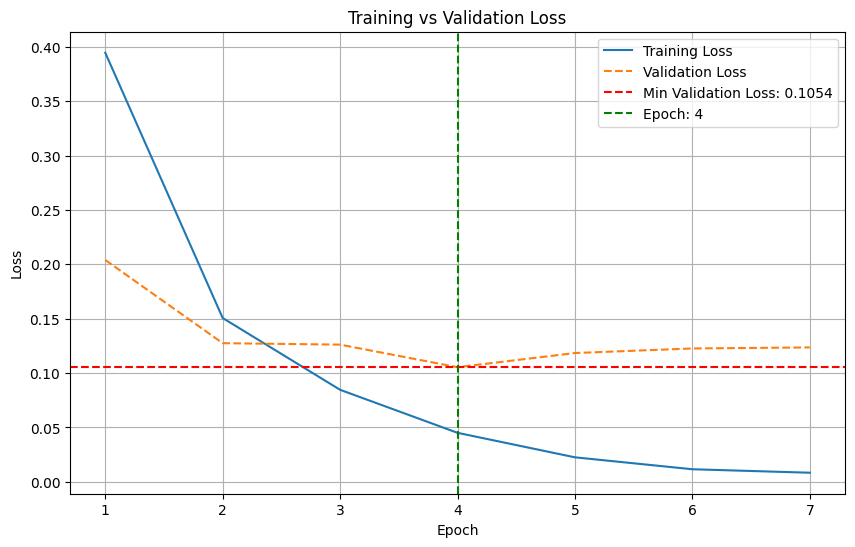

Macro-Averaged F1 Score: 0.5513

Micro-Averaged F1 Score: 0.7099

Weigthed-Averaged F1 Score: 0.7109

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2857     0.4444     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8992     0.8560     0.8770     125       

I-Activity                          0.9000     0.8182     0.8571     11        

B-Activity Data                     0.8319     0.7833     0.8069     120       

I-Activity Data                     0.6400     0.7080     0.6723     113       

B-Actor                             0.7736     0.7387     0.7558     111       

I-Actor                             0.5741     0.6526     0.6108     95        

B-Condition Specification           0.6667     0.7500     0.7059     16        

I-Condition Specification           0.2286     0.5000     0.3137     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5250, Precision: 0.8484, Recall: 0.8584, F1: 0.8531
Step 50, Loss: 0.3054, Precision: 0.9242, Recall: 0.9273, F1: 0.9230
Average training loss: 0.4049

Macro-Averaged F1 Score: 0.1600

Micro-Averaged F1 Score: 0.3718

Weigthed-Averaged F1 Score: 0.3556

Epoch 2/7
Training...
Step 0, Loss: 0.2590, Precision: 0.9229, Recall: 0.9302, F1: 0.9247
Step 50, Loss: 0.0899, Precision: 0.9455, Recall: 0.9559, F1: 0.9502
Average training loss: 0.1577

Macro-Averaged F1 Score: 0.3113

Micro-Averaged F1 Score: 0.5687

Weigthed-Averaged F1 Score: 0.5641

Epoch 3/7
Training...
Step 0, Loss: 0.1295, Precision: 0.9451, Recall: 0.9566, F1: 0.9503
Step 50, Loss: 0.0475, Precision: 0.9558, Recall: 0.9632, F1: 0.9575
Average training loss: 0.0807

Macro-Averaged F1 Score: 0.4329

Micro-Averaged F1 Score: 0.6341

Weigthed-Averaged F1 Score: 0.6315

Epoch 4/7
Training...
Step 0, Loss: 0.0876, Precision: 0.9586, Recall: 0.9641, F1: 0.9594
Step 50, Loss: 0.0554, Precision: 

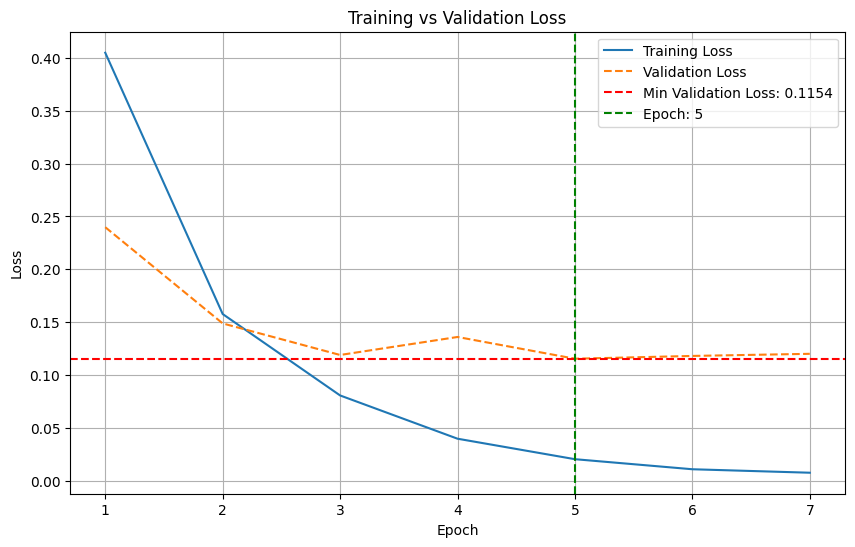

Macro-Averaged F1 Score: 0.5834

Micro-Averaged F1 Score: 0.7091

Weigthed-Averaged F1 Score: 0.7144

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.4000     0.2222     0.2857     9         

I-AND Gateway                       0.3333     0.3333     0.3333     3         

B-Activity                          0.8209     0.9402     0.8765     117       

I-Activity                          0.8000     0.4444     0.5714     9         

B-Activity Data                     0.8214     0.8440     0.8326     109       

I-Activity Data                     0.5252     0.7604     0.6213     96        

B-Actor                             0.8600     0.8776     0.8687     98        

I-Actor                             0.7526     0.8690     0.8066     84        

B-Condition Specification           0.7917     0.8261     0.8085     23        

I-Condition Specification           0.5278     0.8261     0.6441     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8338, Precision: 0.8238, Recall: 0.7871, F1: 0.8047
Step 50, Loss: 0.3414, Precision: 0.9140, Recall: 0.9375, F1: 0.9238
Average training loss: 0.4088

Macro-Averaged F1 Score: 0.2382

Micro-Averaged F1 Score: 0.4938

Weigthed-Averaged F1 Score: 0.4773

Epoch 2/7
Training...
Step 0, Loss: 0.1993, Precision: 0.9194, Recall: 0.9403, F1: 0.9284
Step 50, Loss: 0.1298, Precision: 0.9562, Recall: 0.9626, F1: 0.9568
Average training loss: 0.1475

Macro-Averaged F1 Score: 0.4077

Micro-Averaged F1 Score: 0.6525

Weigthed-Averaged F1 Score: 0.6418

Epoch 3/7
Training...
Step 0, Loss: 0.1267, Precision: 0.9594, Recall: 0.9652, F1: 0.9600
Step 50, Loss: 0.0809, Precision: 0.9710, Recall: 0.9698, F1: 0.9696
Average training loss: 0.0757

Macro-Averaged F1 Score: 0.5442

Micro-Averaged F1 Score: 0.7617

Weigthed-Averaged F1 Score: 0.7631

Epoch 4/7
Training...
Step 0, Loss: 0.1074, Precision: 0.9707, Recall: 0.9694, F1: 0.9692
Step 50, Loss: 0.0068, Precision: 

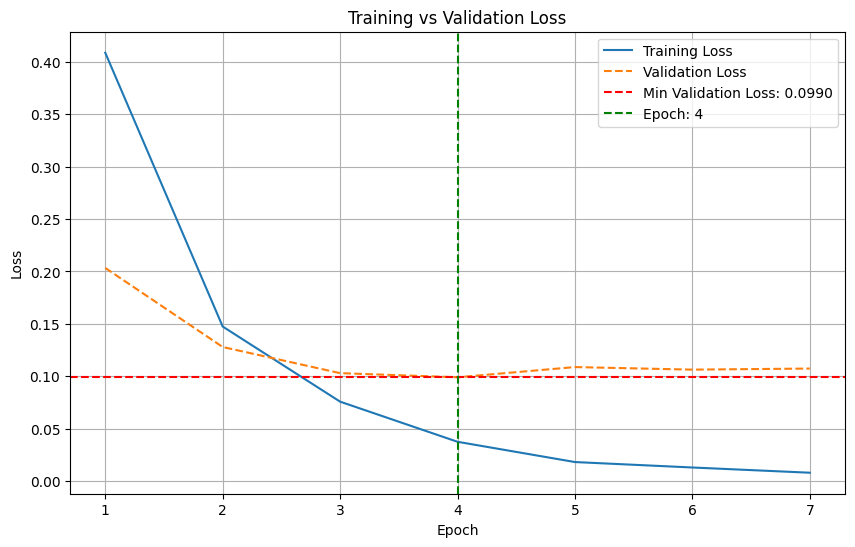

Macro-Averaged F1 Score: 0.5847

Micro-Averaged F1 Score: 0.7837

Weigthed-Averaged F1 Score: 0.7851

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8889     0.9697     0.9275     132       

I-Activity                          0.6667     0.2857     0.4000     7         

B-Activity Data                     0.8189     0.8525     0.8353     122       

I-Activity Data                     0.6204     0.7870     0.6939     108       

B-Actor                             0.8881     0.9084     0.8981     131       

I-Actor                             0.8348     0.8889     0.8610     108       

B-Condition Specification           0.7857     0.5238     0.6286     21        

I-Condition Specification           0.6250     0.5263     0.5714     19        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7471, Precision: 0.8385, Recall: 0.7348, F1: 0.7824
Step 50, Loss: 0.2773, Precision: 0.9371, Recall: 0.9492, F1: 0.9404
Average training loss: 0.4032

Macro-Averaged F1 Score: 0.2182

Micro-Averaged F1 Score: 0.4688

Weigthed-Averaged F1 Score: 0.4438

Epoch 2/7
Training...
Step 0, Loss: 0.1640, Precision: 0.9337, Recall: 0.9477, F1: 0.9373
Step 50, Loss: 0.0664, Precision: 0.9645, Recall: 0.9649, F1: 0.9630
Average training loss: 0.1450

Macro-Averaged F1 Score: 0.3860

Micro-Averaged F1 Score: 0.6470

Weigthed-Averaged F1 Score: 0.6370

Epoch 3/7
Training...
Step 0, Loss: 0.1010, Precision: 0.9657, Recall: 0.9637, F1: 0.9629
Step 50, Loss: 0.0500, Precision: 0.9692, Recall: 0.9681, F1: 0.9675
Average training loss: 0.0779

Macro-Averaged F1 Score: 0.4332

Micro-Averaged F1 Score: 0.6826

Weigthed-Averaged F1 Score: 0.6891

Epoch 4/7
Training...
Step 0, Loss: 0.0869, Precision: 0.9690, Recall: 0.9691, F1: 0.9680
Step 50, Loss: 0.0343, Precision: 

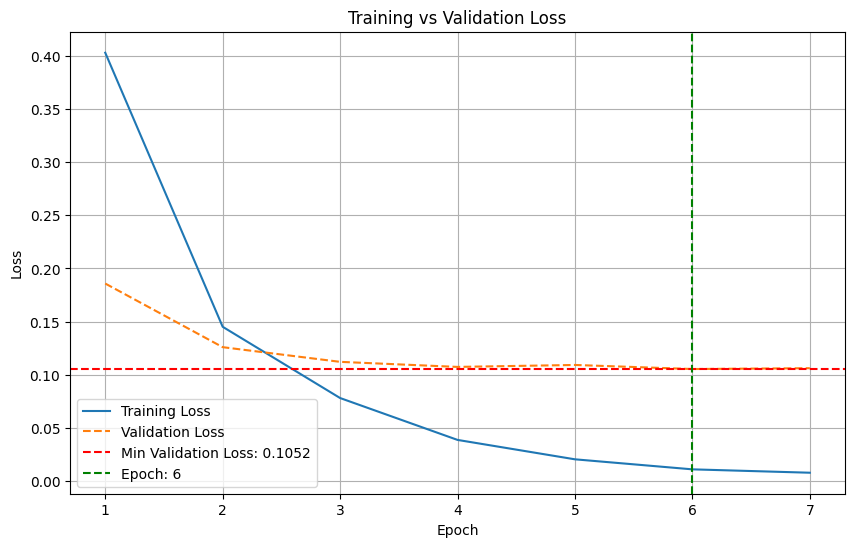

Macro-Averaged F1 Score: 0.5420

Micro-Averaged F1 Score: 0.7403

Weigthed-Averaged F1 Score: 0.7435

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.3636     0.4706     11        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8268     0.9292     0.8750     113       

I-Activity                          0.5000     0.4000     0.4444     5         

B-Activity Data                     0.7679     0.8037     0.7854     107       

I-Activity Data                     0.5917     0.7553     0.6636     94        

B-Actor                             0.9020     0.9293     0.9154     99        

I-Actor                             0.8542     0.9318     0.8913     88        

B-Condition Specification           0.8095     0.6538     0.7234     26        

I-Condition Specification           0.4516     0.5600     0.5000     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.4760, Precision: 0.8406, Recall: 0.8849, F1: 0.8622
Step 50, Loss: 0.1687, Precision: 0.9418, Recall: 0.9550, F1: 0.9461
Average training loss: 0.3050

Macro-Averaged F1 Score: 0.3006

Micro-Averaged F1 Score: 0.5402

Weigthed-Averaged F1 Score: 0.5251

Epoch 2/7
Training...
Step 0, Loss: 0.1086, Precision: 0.9490, Recall: 0.9569, F1: 0.9506
Step 50, Loss: 0.0828, Precision: 0.9641, Recall: 0.9674, F1: 0.9620
Average training loss: 0.0921

Macro-Averaged F1 Score: 0.4612

Micro-Averaged F1 Score: 0.7052

Weigthed-Averaged F1 Score: 0.6866

Epoch 3/7
Training...
Step 0, Loss: 0.0541, Precision: 0.9640, Recall: 0.9670, F1: 0.9615
Step 50, Loss: 0.0291, Precision: 0.9679, Recall: 0.9702, F1: 0.9682
Average training loss: 0.0367

Macro-Averaged F1 Score: 0.5632

Micro-Averaged F1 Score: 0.7318

Weigthed-Averaged F1 Score: 0.7348

Epoch 4/7
Training...
Step 0, Loss: 0.0360, Precision: 0.9678, Recall: 0.9703, F1: 0.9681
Step 50, Loss: 0.0061, Precision: 

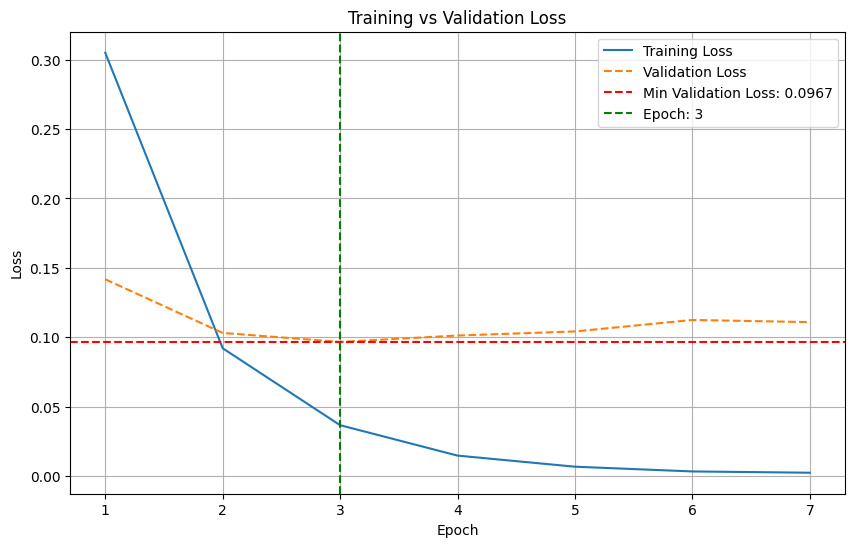

Macro-Averaged F1 Score: 0.6287

Micro-Averaged F1 Score: 0.7510

Weigthed-Averaged F1 Score: 0.7527

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.7500     0.4286     0.5455     7         

I-AND Gateway                       0.1429     0.3333     0.2000     3         

B-Activity                          0.8636     0.9048     0.8837     126       

I-Activity                          0.7500     0.5000     0.6000     12        

B-Activity Data                     0.8220     0.8818     0.8509     110       

I-Activity Data                     0.6077     0.7670     0.6781     103       

B-Actor                             0.9038     0.9126     0.9082     103       

I-Actor                             0.6700     0.8072     0.7322     83        

B-Condition Specification           1.0000     0.5833     0.7368     12        

I-Condition Specification           0.5455     0.5000     0.5217     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8645, Precision: 0.8318, Recall: 0.8273, F1: 0.8294
Step 50, Loss: 0.2818, Precision: 0.9417, Recall: 0.9525, F1: 0.9461
Average training loss: 0.3552

Macro-Averaged F1 Score: 0.2858

Micro-Averaged F1 Score: 0.5437

Weigthed-Averaged F1 Score: 0.5383

Epoch 2/7
Training...
Step 0, Loss: 0.1559, Precision: 0.9434, Recall: 0.9532, F1: 0.9478
Step 50, Loss: 0.0659, Precision: 0.9604, Recall: 0.9659, F1: 0.9624
Average training loss: 0.1095

Macro-Averaged F1 Score: 0.4020

Micro-Averaged F1 Score: 0.7016

Weigthed-Averaged F1 Score: 0.6909

Epoch 3/7
Training...
Step 0, Loss: 0.0667, Precision: 0.9603, Recall: 0.9657, F1: 0.9622
Step 50, Loss: 0.0203, Precision: 0.9650, Recall: 0.9689, F1: 0.9655
Average training loss: 0.0416

Macro-Averaged F1 Score: 0.5480

Micro-Averaged F1 Score: 0.7213

Weigthed-Averaged F1 Score: 0.7208

Epoch 4/7
Training...
Step 0, Loss: 0.0371, Precision: 0.9684, Recall: 0.9694, F1: 0.9681
Step 50, Loss: 0.0159, Precision: 

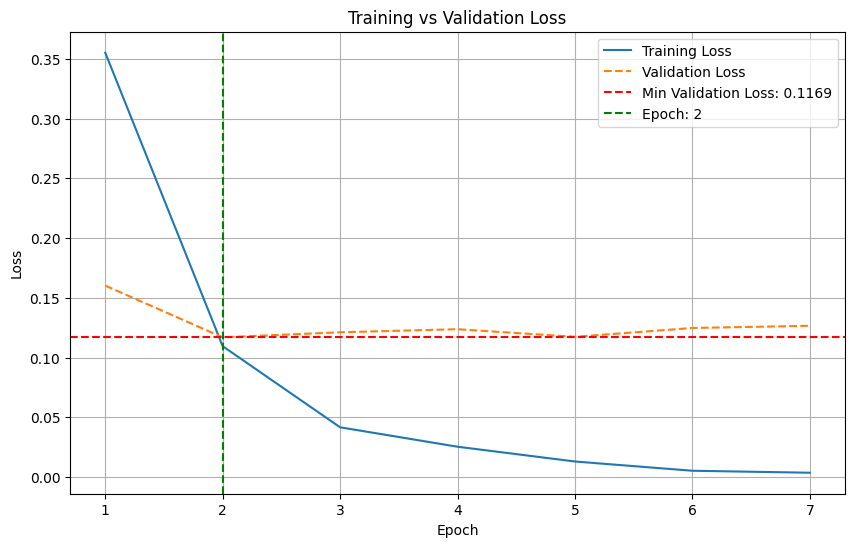

Macro-Averaged F1 Score: 0.6104

Micro-Averaged F1 Score: 0.7519

Weigthed-Averaged F1 Score: 0.7574

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.4286     0.6000     7         

I-AND Gateway                       0.5000     0.2500     0.3333     4         

B-Activity                          0.9098     0.8880     0.8988     125       

I-Activity                          0.9000     0.8182     0.8571     11        

B-Activity Data                     0.8621     0.8333     0.8475     120       

I-Activity Data                     0.6692     0.7876     0.7236     113       

B-Actor                             0.8083     0.8739     0.8398     111       

I-Actor                             0.7009     0.7895     0.7426     95        

B-Condition Specification           0.6190     0.8125     0.7027     16        

I-Condition Specification           0.3235     0.6875     0.4400     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9090, Precision: 0.8482, Recall: 0.8735, F1: 0.8601
Step 50, Loss: 0.1160, Precision: 0.9462, Recall: 0.9422, F1: 0.9419
Average training loss: 0.3497

Macro-Averaged F1 Score: 0.2935

Micro-Averaged F1 Score: 0.5462

Weigthed-Averaged F1 Score: 0.5417

Epoch 2/7
Training...
Step 0, Loss: 0.1701, Precision: 0.9469, Recall: 0.9403, F1: 0.9409
Step 50, Loss: 0.0545, Precision: 0.9565, Recall: 0.9614, F1: 0.9560
Average training loss: 0.1113

Macro-Averaged F1 Score: 0.4029

Micro-Averaged F1 Score: 0.6360

Weigthed-Averaged F1 Score: 0.6321

Epoch 3/7
Training...
Step 0, Loss: 0.0960, Precision: 0.9568, Recall: 0.9612, F1: 0.9566
Step 50, Loss: 0.0707, Precision: 0.9652, Recall: 0.9673, F1: 0.9642
Average training loss: 0.0529

Macro-Averaged F1 Score: 0.5474

Micro-Averaged F1 Score: 0.7216

Weigthed-Averaged F1 Score: 0.7219

Epoch 4/7
Training...
Step 0, Loss: 0.0770, Precision: 0.9637, Recall: 0.9665, F1: 0.9640
Step 50, Loss: 0.0141, Precision: 

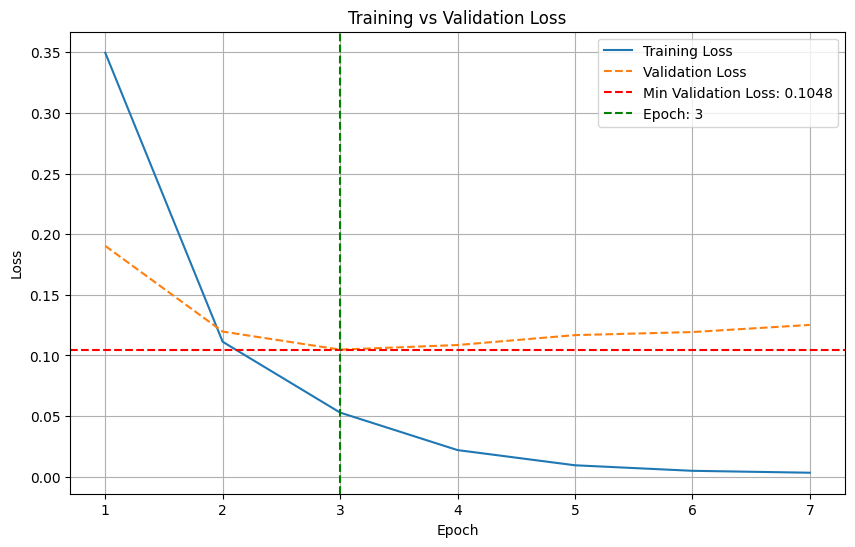

Macro-Averaged F1 Score: 0.6060

Micro-Averaged F1 Score: 0.7492

Weigthed-Averaged F1 Score: 0.7541

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.2222     0.3077     9         

I-AND Gateway                       0.1429     0.3333     0.2000     3         

B-Activity                          0.8800     0.9402     0.9091     117       

I-Activity                          0.6250     0.5556     0.5882     9         

B-Activity Data                     0.8468     0.8624     0.8545     109       

I-Activity Data                     0.5357     0.7812     0.6356     96        

B-Actor                             0.8687     0.8776     0.8731     98        

I-Actor                             0.7865     0.8333     0.8092     84        

B-Condition Specification           0.8261     0.8261     0.8261     23        

I-Condition Specification           0.7200     0.7826     0.7500     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8604, Precision: 0.8079, Recall: 0.8259, F1: 0.8167
Step 50, Loss: 0.1320, Precision: 0.9458, Recall: 0.9521, F1: 0.9471
Average training loss: 0.3831

Macro-Averaged F1 Score: 0.3074

Micro-Averaged F1 Score: 0.5873

Weigthed-Averaged F1 Score: 0.5841

Epoch 2/7
Training...
Step 0, Loss: 0.1477, Precision: 0.9476, Recall: 0.9539, F1: 0.9490
Step 50, Loss: 0.1245, Precision: 0.9646, Recall: 0.9708, F1: 0.9664
Average training loss: 0.1230

Macro-Averaged F1 Score: 0.4577

Micro-Averaged F1 Score: 0.7281

Weigthed-Averaged F1 Score: 0.7142

Epoch 3/7
Training...
Step 0, Loss: 0.0542, Precision: 0.9630, Recall: 0.9700, F1: 0.9653
Step 50, Loss: 0.0598, Precision: 0.9725, Recall: 0.9718, F1: 0.9718
Average training loss: 0.0587

Macro-Averaged F1 Score: 0.5456

Micro-Averaged F1 Score: 0.7458

Weigthed-Averaged F1 Score: 0.7541

Epoch 4/7
Training...
Step 0, Loss: 0.0262, Precision: 0.9725, Recall: 0.9715, F1: 0.9716
Step 50, Loss: 0.0303, Precision: 

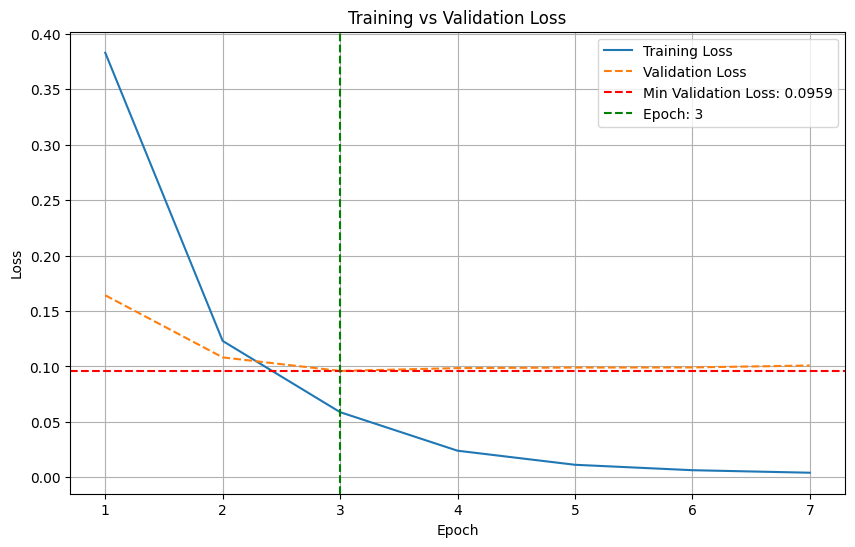

Macro-Averaged F1 Score: 0.6064

Micro-Averaged F1 Score: 0.7986

Weigthed-Averaged F1 Score: 0.8008

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     6         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8671     0.9394     0.9018     132       

I-Activity                          0.7500     0.4286     0.5455     7         

B-Activity Data                     0.8561     0.9262     0.8898     122       

I-Activity Data                     0.6439     0.7870     0.7083     108       

B-Actor                             0.8931     0.8931     0.8931     131       

I-Actor                             0.8190     0.8796     0.8482     108       

B-Condition Specification           0.8000     0.5714     0.6667     21        

I-Condition Specification           0.4545     0.5263     0.4878     19        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7296, Precision: 0.8471, Recall: 0.8823, F1: 0.8643
Step 50, Loss: 0.1958, Precision: 0.9504, Recall: 0.9538, F1: 0.9481
Average training loss: 0.3575

Macro-Averaged F1 Score: 0.2553

Micro-Averaged F1 Score: 0.5628

Weigthed-Averaged F1 Score: 0.5267

Epoch 2/7
Training...
Step 0, Loss: 0.2442, Precision: 0.9504, Recall: 0.9548, F1: 0.9491
Step 50, Loss: 0.1832, Precision: 0.9647, Recall: 0.9669, F1: 0.9645
Average training loss: 0.1143

Macro-Averaged F1 Score: 0.4045

Micro-Averaged F1 Score: 0.6677

Weigthed-Averaged F1 Score: 0.6569

Epoch 3/7
Training...
Step 0, Loss: 0.0861, Precision: 0.9649, Recall: 0.9667, F1: 0.9645
Step 50, Loss: 0.1078, Precision: 0.9731, Recall: 0.9706, F1: 0.9707
Average training loss: 0.0527

Macro-Averaged F1 Score: 0.5059

Micro-Averaged F1 Score: 0.6961

Weigthed-Averaged F1 Score: 0.7051

Epoch 4/7
Training...
Step 0, Loss: 0.0453, Precision: 0.9730, Recall: 0.9708, F1: 0.9707
Step 50, Loss: 0.0213, Precision: 

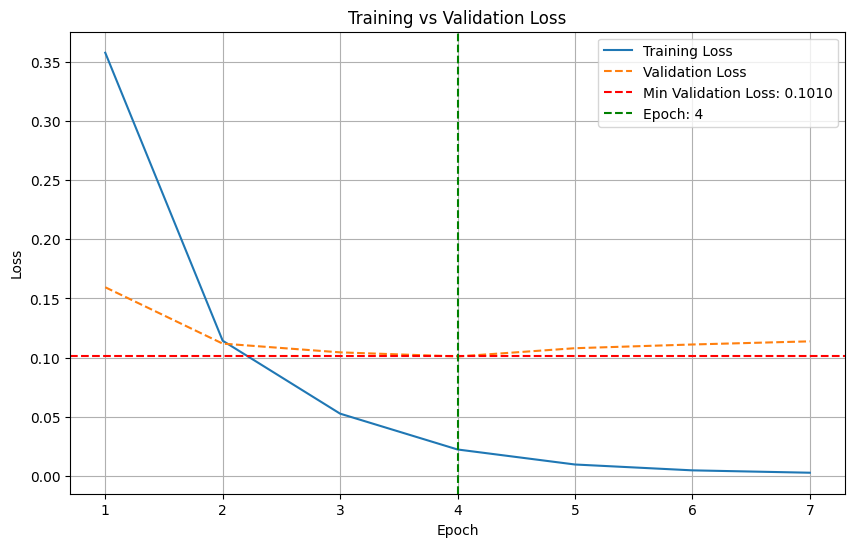

Macro-Averaged F1 Score: 0.5623

Micro-Averaged F1 Score: 0.7239

Weigthed-Averaged F1 Score: 0.7320

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.6667     0.3636     0.4706     11        

I-AND Gateway                       0.1667     0.1667     0.1667     6         

B-Activity                          0.7970     0.9381     0.8618     113       

I-Activity                          0.3333     0.6000     0.4286     5         

B-Activity Data                     0.7658     0.7944     0.7798     107       

I-Activity Data                     0.5833     0.7447     0.6542     94        

B-Actor                             0.8812     0.8990     0.8900     99        

I-Actor                             0.8351     0.9205     0.8757     88        

B-Condition Specification           0.7826     0.6923     0.7347     26        

I-Condition Specification           0.6000     0.7200     0.6545     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8887, Precision: 0.8431, Recall: 0.8891, F1: 0.8655
Step 50, Loss: 0.1776, Precision: 0.9450, Recall: 0.9581, F1: 0.9502
Average training loss: 0.3398

Macro-Averaged F1 Score: 0.3212

Micro-Averaged F1 Score: 0.6055

Weigthed-Averaged F1 Score: 0.5775

Epoch 2/7
Training...
Step 0, Loss: 0.1247, Precision: 0.9470, Recall: 0.9570, F1: 0.9502
Step 50, Loss: 0.0714, Precision: 0.9593, Recall: 0.9638, F1: 0.9587
Average training loss: 0.0964

Macro-Averaged F1 Score: 0.4319

Micro-Averaged F1 Score: 0.6737

Weigthed-Averaged F1 Score: 0.6566

Epoch 3/7
Training...
Step 0, Loss: 0.0417, Precision: 0.9596, Recall: 0.9632, F1: 0.9583
Step 50, Loss: 0.0499, Precision: 0.9623, Recall: 0.9654, F1: 0.9593
Average training loss: 0.0494

Macro-Averaged F1 Score: 0.4986

Micro-Averaged F1 Score: 0.6873

Weigthed-Averaged F1 Score: 0.6798

Epoch 4/7
Training...
Step 0, Loss: 0.0485, Precision: 0.9645, Recall: 0.9665, F1: 0.9617
Step 50, Loss: 0.0021, Precision: 

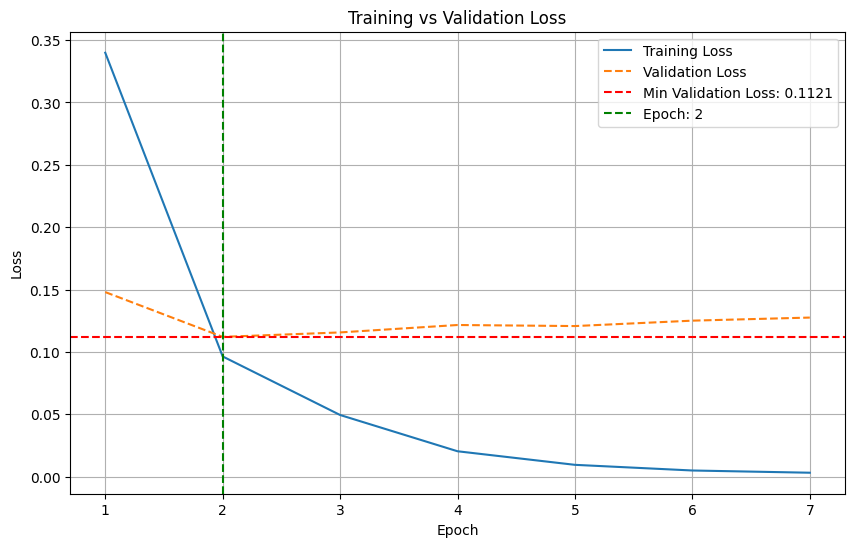

Macro-Averaged F1 Score: 0.6253

Micro-Averaged F1 Score: 0.7400

Weigthed-Averaged F1 Score: 0.7416

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.4286     0.4286     0.4286     7         

I-AND Gateway                       0.1667     0.3333     0.2222     3         

B-Activity                          0.8855     0.9206     0.9027     126       

I-Activity                          0.9000     0.7500     0.8182     12        

B-Activity Data                     0.8421     0.8727     0.8571     110       

I-Activity Data                     0.6333     0.7379     0.6816     103       

B-Actor                             0.8519     0.8932     0.8720     103       

I-Actor                             0.6947     0.7952     0.7416     83        

B-Condition Specification           0.8889     0.6667     0.7619     12        

I-Condition Specification           0.5000     0.5000     0.5000     12        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8120, Precision: 0.8257, Recall: 0.8679, F1: 0.8462
Step 50, Loss: 0.1437, Precision: 0.9314, Recall: 0.9457, F1: 0.9318
Average training loss: 0.3749

Macro-Averaged F1 Score: 0.2292

Micro-Averaged F1 Score: 0.4903

Weigthed-Averaged F1 Score: 0.4707

Epoch 2/7
Training...
Step 0, Loss: 0.0639, Precision: 0.9321, Recall: 0.9477, F1: 0.9352
Step 50, Loss: 0.0810, Precision: 0.9601, Recall: 0.9640, F1: 0.9615
Average training loss: 0.1206

Macro-Averaged F1 Score: 0.3739

Micro-Averaged F1 Score: 0.6704

Weigthed-Averaged F1 Score: 0.6672

Epoch 3/7
Training...
Step 0, Loss: 0.0642, Precision: 0.9600, Recall: 0.9638, F1: 0.9613
Step 50, Loss: 0.0523, Precision: 0.9702, Recall: 0.9619, F1: 0.9641
Average training loss: 0.0548

Macro-Averaged F1 Score: 0.4807

Micro-Averaged F1 Score: 0.6970

Weigthed-Averaged F1 Score: 0.7093

Epoch 4/7
Training...
Step 0, Loss: 0.0896, Precision: 0.9694, Recall: 0.9624, F1: 0.9645
Step 50, Loss: 0.0042, Precision: 

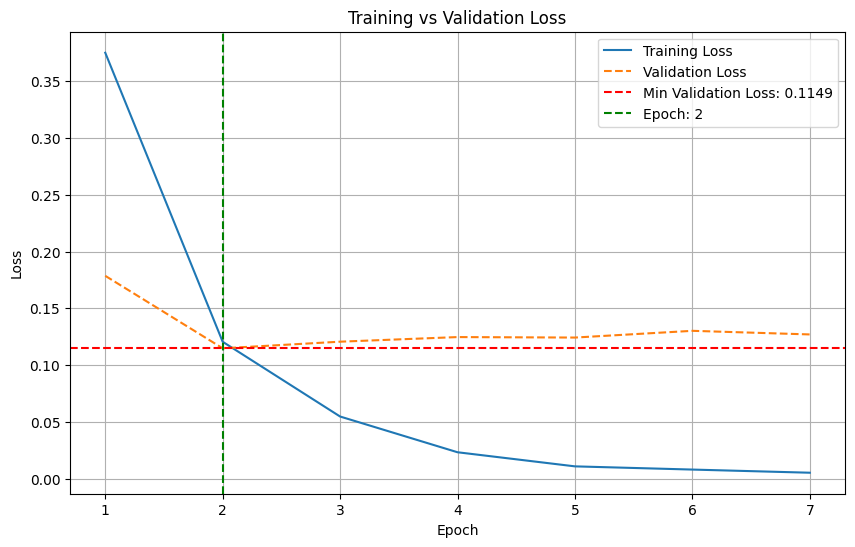

Macro-Averaged F1 Score: 0.5806

Micro-Averaged F1 Score: 0.7346

Weigthed-Averaged F1 Score: 0.7403

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2857     0.4444     7         

I-AND Gateway                       0.2000     0.2500     0.2222     4         

B-Activity                          0.8730     0.8800     0.8765     125       

I-Activity                          1.0000     0.9091     0.9524     11        

B-Activity Data                     0.7795     0.8250     0.8016     120       

I-Activity Data                     0.6165     0.7257     0.6667     113       

B-Actor                             0.7581     0.8468     0.8000     111       

I-Actor                             0.7379     0.8000     0.7677     95        

B-Condition Specification           0.5882     0.6250     0.6061     16        

I-Condition Specification           0.2857     0.5000     0.3636     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8115, Precision: 0.8432, Recall: 0.8984, F1: 0.8699
Step 50, Loss: 0.1824, Precision: 0.9220, Recall: 0.9390, F1: 0.9299
Average training loss: 0.3622

Macro-Averaged F1 Score: 0.2069

Micro-Averaged F1 Score: 0.4589

Weigthed-Averaged F1 Score: 0.4338

Epoch 2/7
Training...
Step 0, Loss: 0.2061, Precision: 0.9243, Recall: 0.9399, F1: 0.9313
Step 50, Loss: 0.0983, Precision: 0.9532, Recall: 0.9595, F1: 0.9507
Average training loss: 0.1279

Macro-Averaged F1 Score: 0.3546

Micro-Averaged F1 Score: 0.6095

Weigthed-Averaged F1 Score: 0.5980

Epoch 3/7
Training...
Step 0, Loss: 0.0610, Precision: 0.9462, Recall: 0.9553, F1: 0.9447
Step 50, Loss: 0.0305, Precision: 0.9651, Recall: 0.9630, F1: 0.9621
Average training loss: 0.0594

Macro-Averaged F1 Score: 0.5412

Micro-Averaged F1 Score: 0.6959

Weigthed-Averaged F1 Score: 0.7020

Epoch 4/7
Training...
Step 0, Loss: 0.0298, Precision: 0.9647, Recall: 0.9624, F1: 0.9617
Step 50, Loss: 0.0073, Precision: 

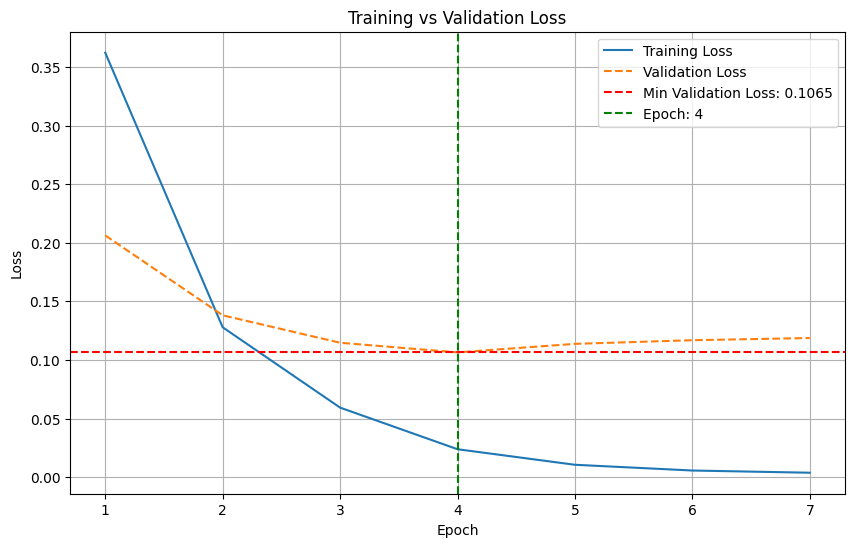

Macro-Averaged F1 Score: 0.5735

Micro-Averaged F1 Score: 0.7208

Weigthed-Averaged F1 Score: 0.7252

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1111     0.1818     9         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8385     0.9316     0.8826     117       

I-Activity                          0.5000     0.4444     0.4706     9         

B-Activity Data                     0.8034     0.8624     0.8319     109       

I-Activity Data                     0.5368     0.7604     0.6293     96        

B-Actor                             0.8019     0.8673     0.8333     98        

I-Actor                             0.7368     0.8333     0.7821     84        

B-Condition Specification           0.8824     0.6522     0.7500     23        

I-Condition Specification           0.6800     0.7391     0.7083     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7323, Precision: 0.8093, Recall: 0.8701, F1: 0.8386
Step 50, Loss: 0.1385, Precision: 0.9469, Recall: 0.9532, F1: 0.9491
Average training loss: 0.3381

Macro-Averaged F1 Score: 0.3422

Micro-Averaged F1 Score: 0.6071

Weigthed-Averaged F1 Score: 0.6052

Epoch 2/7
Training...
Step 0, Loss: 0.0837, Precision: 0.9475, Recall: 0.9544, F1: 0.9500
Step 50, Loss: 0.0729, Precision: 0.9699, Recall: 0.9732, F1: 0.9710
Average training loss: 0.1112

Macro-Averaged F1 Score: 0.4854

Micro-Averaged F1 Score: 0.7451

Weigthed-Averaged F1 Score: 0.7387

Epoch 3/7
Training...
Step 0, Loss: 0.0271, Precision: 0.9700, Recall: 0.9732, F1: 0.9710
Step 50, Loss: 0.0457, Precision: 0.9731, Recall: 0.9724, F1: 0.9723
Average training loss: 0.0455

Macro-Averaged F1 Score: 0.5267

Micro-Averaged F1 Score: 0.7458

Weigthed-Averaged F1 Score: 0.7545

Epoch 4/7
Training...
Step 0, Loss: 0.0577, Precision: 0.9727, Recall: 0.9732, F1: 0.9725
Step 50, Loss: 0.0294, Precision: 

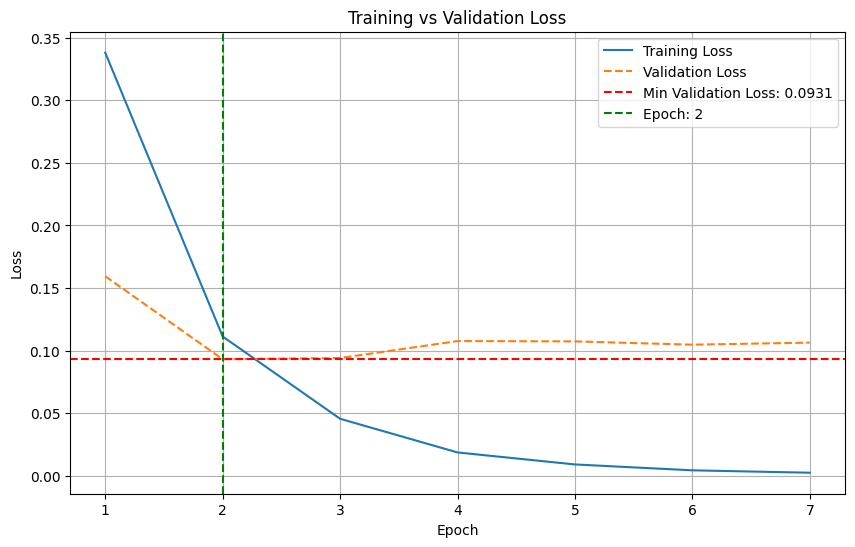

Macro-Averaged F1 Score: 0.6133

Micro-Averaged F1 Score: 0.7804

Weigthed-Averaged F1 Score: 0.7855

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.3333     0.1667     0.2222     6         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8849     0.9318     0.9077     132       

I-Activity                          0.6000     0.4286     0.5000     7         

B-Activity Data                     0.8333     0.9016     0.8661     122       

I-Activity Data                     0.6214     0.8056     0.7016     108       

B-Actor                             0.9015     0.9084     0.9049     131       

I-Actor                             0.7881     0.8611     0.8230     108       

B-Condition Specification           0.7647     0.6190     0.6842     21        

I-Condition Specification           0.3750     0.4737     0.4186     19        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7980, Precision: 0.8471, Recall: 0.8926, F1: 0.8686
Step 50, Loss: 0.1630, Precision: 0.9527, Recall: 0.9619, F1: 0.9569
Average training loss: 0.3369

Macro-Averaged F1 Score: 0.3171

Micro-Averaged F1 Score: 0.5966

Weigthed-Averaged F1 Score: 0.5812

Epoch 2/7
Training...
Step 0, Loss: 0.1655, Precision: 0.9554, Recall: 0.9634, F1: 0.9590
Step 50, Loss: 0.1087, Precision: 0.9512, Recall: 0.9592, F1: 0.9512
Average training loss: 0.1002

Macro-Averaged F1 Score: 0.3359

Micro-Averaged F1 Score: 0.6240

Weigthed-Averaged F1 Score: 0.5998

Epoch 3/7
Training...
Step 0, Loss: 0.1003, Precision: 0.9495, Recall: 0.9580, F1: 0.9495
Step 50, Loss: 0.0381, Precision: 0.9715, Recall: 0.9705, F1: 0.9696
Average training loss: 0.0502

Macro-Averaged F1 Score: 0.5656

Micro-Averaged F1 Score: 0.7195

Weigthed-Averaged F1 Score: 0.7208

Epoch 4/7
Training...
Step 0, Loss: 0.0442, Precision: 0.9716, Recall: 0.9701, F1: 0.9694
Step 50, Loss: 0.0378, Precision: 

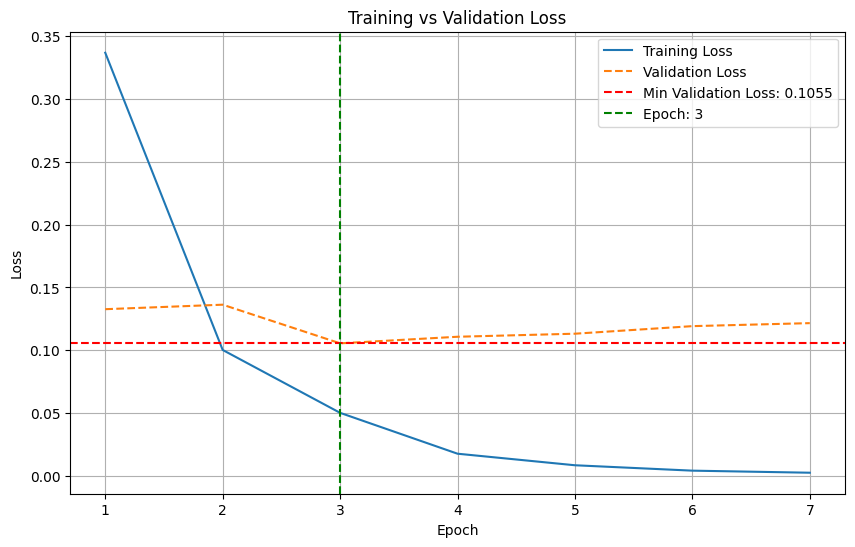

Macro-Averaged F1 Score: 0.6044

Micro-Averaged F1 Score: 0.7434

Weigthed-Averaged F1 Score: 0.7446

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.8000     0.3636     0.5000     11        

I-AND Gateway                       0.2000     0.1667     0.1818     6         

B-Activity                          0.7591     0.9204     0.8320     113       

I-Activity                          0.2222     0.4000     0.2857     5         

B-Activity Data                     0.7521     0.8505     0.7982     107       

I-Activity Data                     0.5840     0.7766     0.6667     94        

B-Actor                             0.8598     0.9293     0.8932     99        

I-Actor                             0.8182     0.9205     0.8663     88        

B-Condition Specification           0.8182     0.6923     0.7500     26        

I-Condition Specification           0.5161     0.6400     0.5714     25        

B-Furth

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]
result_lr = {}

for lr in learning_rates:
    print("\n---------------------------------------")
    print(f"Learning Rate: {lr}")
    print("---------------------------------------\n")
    lr_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, EPOCHS, label_map, lr)

    # Initialize the entry for this learning rate
    result_lr[lr] = {'avg_macro_f1': avg_macro_f1, 'avg_micro_f1':avg_micro_f1, 'avg_weight_f1': avg_weight_f1,  'label_f1': {}}

    for label, scores in label_f1.items():
        try:
            average_f1 = sum(scores) / len(scores)
            result_lr[lr]['label_f1'][label] = average_f1
        except ZeroDivisionError as zero:
            print(f"Zero division error for label {label}")

# Print the result to verify
print(result_lr)


In [ ]:
for item in result_lr:
  print('Learning rate:', item)
  print('macro avg f1 for all folds: ', round(result_lr[item]['avg_macro_f1'],4))
  print('micro avg f1 for all folds: ', round(result_lr[item]['avg_micro_f1'],4))
  print('weighted avg f1 for all folds: ', round(result_lr[item]['avg_weight_f1'],4))
  for label, score in result_lr[item]['label_f1'].items():
    if label.startswith("B-AND") or label.startswith("I-AND"):
      print(label, round(score,2))
  print('----')

Learning rate: 2e-05
macro avg f1 for all folds:  0.481
micro avg f1 for all folds:  0.6947
weighted avg f1 for all folds:  0.6941
B-AND Gateway 0.09
I-AND Gateway 0.0
----
Learning rate: 3e-05
macro avg f1 for all folds:  0.5718
micro avg f1 for all folds:  0.7368
weighted avg f1 for all folds:  0.7387
B-AND Gateway 0.35
I-AND Gateway 0.07
----
Learning rate: 4e-05
macro avg f1 for all folds:  0.6028
micro avg f1 for all folds:  0.7549
weighted avg f1 for all folds:  0.7594
B-AND Gateway 0.38
I-AND Gateway 0.18
----
Learning rate: 5e-05
macro avg f1 for all folds:  0.5994
micro avg f1 for all folds:  0.7438
weighted avg f1 for all folds:  0.7474
B-AND Gateway 0.36
I-AND Gateway 0.13
----


Fold 1


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.6541, Precision: 0.8397, Recall: 0.8693, F1: 0.8542
Step 50, Loss: 0.1989, Precision: 0.9204, Recall: 0.9426, F1: 0.9290
Average training loss: 0.3515

Macro-Averaged F1 Score: 0.1896

Micro-Averaged F1 Score: 0.3931

Weigthed-Averaged F1 Score: 0.3835

Epoch 2/5
Training...
Step 0, Loss: 0.1412, Precision: 0.9208, Recall: 0.9429, F1: 0.9293
Step 50, Loss: 0.1054, Precision: 0.9484, Recall: 0.9628, F1: 0.9552
Average training loss: 0.1285

Macro-Averaged F1 Score: 0.4282

Micro-Averaged F1 Score: 0.6547

Weigthed-Averaged F1 Score: 0.6269

Epoch 3/5
Training...
Step 0, Loss: 0.0633, Precision: 0.9488, Recall: 0.9620, F1: 0.9548
Step 50, Loss: 0.0363, Precision: 0.9639, Recall: 0.9661, F1: 0.9624
Average training loss: 0.0780

Macro-Averaged F1 Score: 0.5079

Micro-Averaged F1 Score: 0.6912

Weigthed-Averaged F1 Score: 0.6802

Epoch 4/5
Training...
Step 0, Loss: 0.0688, Precision: 0.9638, Recall: 0.9651, F1: 0.9618
Step 50, Loss: 0.0115, Precision: 

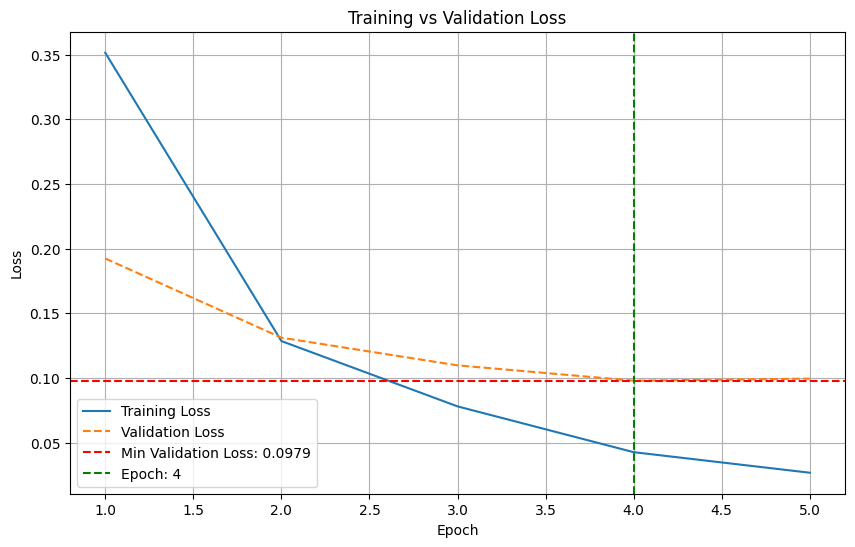

Macro-Averaged F1 Score: 0.5335

Micro-Averaged F1 Score: 0.7060

Weigthed-Averaged F1 Score: 0.6947

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1667     0.2500     6         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8561     0.9576     0.9040     118       

I-Activity                          0.8333     0.4545     0.5882     11        

B-Activity Data                     0.7826     0.8333     0.8072     108       

I-Activity Data                     0.5429     0.7677     0.6360     99        

B-Actor                             0.8000     0.8980     0.8462     98        

I-Actor                             0.6869     0.8395     0.7556     81        

B-Condition Specification           0.8462     0.8462     0.8462     13        

I-Condition Specification           0.5714     0.6154     0.5926     13        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.8938, Precision: 0.8409, Recall: 0.8716, F1: 0.8559
Step 50, Loss: 0.2315, Precision: 0.9353, Recall: 0.9434, F1: 0.9370
Average training loss: 0.3664

Macro-Averaged F1 Score: 0.2636

Micro-Averaged F1 Score: 0.5042

Weigthed-Averaged F1 Score: 0.4872

Epoch 2/5
Training...
Step 0, Loss: 0.2600, Precision: 0.9374, Recall: 0.9443, F1: 0.9387
Step 50, Loss: 0.0663, Precision: 0.9490, Recall: 0.9586, F1: 0.9523
Average training loss: 0.1247

Macro-Averaged F1 Score: 0.3717

Micro-Averaged F1 Score: 0.6351

Weigthed-Averaged F1 Score: 0.6232

Epoch 3/5
Training...
Step 0, Loss: 0.1268, Precision: 0.9516, Recall: 0.9603, F1: 0.9550
Step 50, Loss: 0.0747, Precision: 0.9609, Recall: 0.9626, F1: 0.9604
Average training loss: 0.0668

Macro-Averaged F1 Score: 0.4534

Micro-Averaged F1 Score: 0.6875

Weigthed-Averaged F1 Score: 0.6862

Epoch 4/5
Training...
Step 0, Loss: 0.0651, Precision: 0.9612, Recall: 0.9629, F1: 0.9607
Step 50, Loss: 0.0313, Precision: 

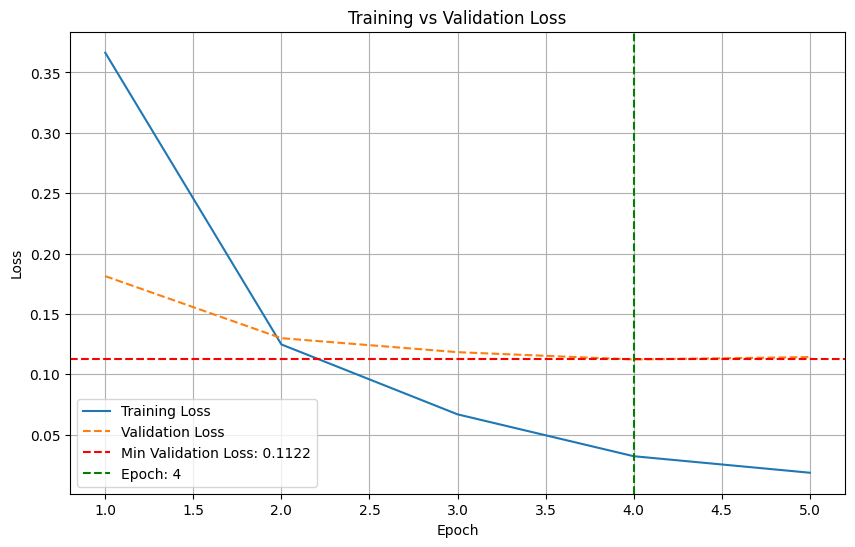

Macro-Averaged F1 Score: 0.5474

Micro-Averaged F1 Score: 0.7132

Weigthed-Averaged F1 Score: 0.7140

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.3333     0.5000     3         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8810     0.9250     0.9024     120       

I-Activity                          0.8000     0.6667     0.7273     12        

B-Activity Data                     0.8496     0.8276     0.8384     116       

I-Activity Data                     0.6614     0.7778     0.7149     108       

B-Actor                             0.7300     0.7300     0.7300     100       

I-Actor                             0.5385     0.6364     0.5833     77        

B-Condition Specification           0.9286     0.5909     0.7222     22        

I-Condition Specification           0.4583     0.5000     0.4783     22        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.7367, Precision: 0.8258, Recall: 0.8619, F1: 0.8434
Step 50, Loss: 0.2110, Precision: 0.9389, Recall: 0.9491, F1: 0.9418
Average training loss: 0.3597

Macro-Averaged F1 Score: 0.2423

Micro-Averaged F1 Score: 0.5000

Weigthed-Averaged F1 Score: 0.4826

Epoch 2/5
Training...
Step 0, Loss: 0.1269, Precision: 0.9386, Recall: 0.9492, F1: 0.9417
Step 50, Loss: 0.0836, Precision: 0.9513, Recall: 0.9615, F1: 0.9547
Average training loss: 0.1248

Macro-Averaged F1 Score: 0.3752

Micro-Averaged F1 Score: 0.6287

Weigthed-Averaged F1 Score: 0.6182

Epoch 3/5
Training...
Step 0, Loss: 0.0992, Precision: 0.9537, Recall: 0.9638, F1: 0.9576
Step 50, Loss: 0.0681, Precision: 0.9653, Recall: 0.9684, F1: 0.9666
Average training loss: 0.0647

Macro-Averaged F1 Score: 0.4792

Micro-Averaged F1 Score: 0.7077

Weigthed-Averaged F1 Score: 0.7089

Epoch 4/5
Training...
Step 0, Loss: 0.0412, Precision: 0.9654, Recall: 0.9692, F1: 0.9669
Step 50, Loss: 0.0824, Precision: 

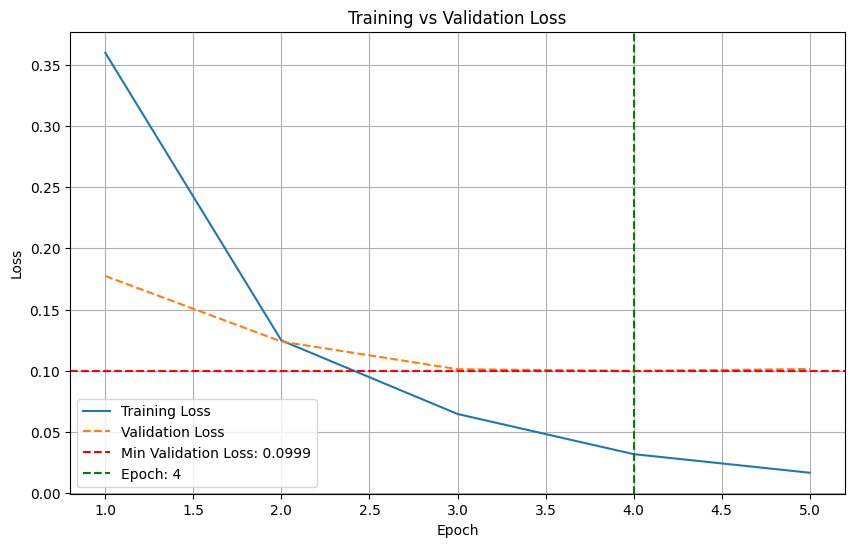

Macro-Averaged F1 Score: 0.5273

Micro-Averaged F1 Score: 0.7361

Weigthed-Averaged F1 Score: 0.7392

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.7500     0.2500     0.3750     12        

I-AND Gateway                       0.0000     0.0000     0.0000     5         

B-Activity                          0.8333     0.8871     0.8594     124       

I-Activity                          1.0000     0.3750     0.5455     8         

B-Activity Data                     0.8220     0.8509     0.8362     114       

I-Activity Data                     0.6562     0.7850     0.7149     107       

B-Actor                             0.9375     0.8898     0.9130     118       

I-Actor                             0.8349     0.8426     0.8387     108       

B-Condition Specification           0.5455     0.5714     0.5581     21        

I-Condition Specification           0.4194     0.6190     0.5000     21        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.9638, Precision: 0.8265, Recall: 0.8193, F1: 0.8229
Step 50, Loss: 0.1129, Precision: 0.9290, Recall: 0.9451, F1: 0.9346
Average training loss: 0.3589

Macro-Averaged F1 Score: 0.2495

Micro-Averaged F1 Score: 0.4852

Weigthed-Averaged F1 Score: 0.4760

Epoch 2/5
Training...
Step 0, Loss: 0.0986, Precision: 0.9304, Recall: 0.9459, F1: 0.9362
Step 50, Loss: 0.1296, Precision: 0.9578, Recall: 0.9610, F1: 0.9572
Average training loss: 0.1137

Macro-Averaged F1 Score: 0.3687

Micro-Averaged F1 Score: 0.6249

Weigthed-Averaged F1 Score: 0.6242

Epoch 3/5
Training...
Step 0, Loss: 0.0652, Precision: 0.9585, Recall: 0.9602, F1: 0.9570
Step 50, Loss: 0.0641, Precision: 0.9572, Recall: 0.9629, F1: 0.9590
Average training loss: 0.0589

Macro-Averaged F1 Score: 0.4224

Micro-Averaged F1 Score: 0.6594

Weigthed-Averaged F1 Score: 0.6608

Epoch 4/5
Training...
Step 0, Loss: 0.0481, Precision: 0.9578, Recall: 0.9630, F1: 0.9595
Step 50, Loss: 0.0211, Precision: 

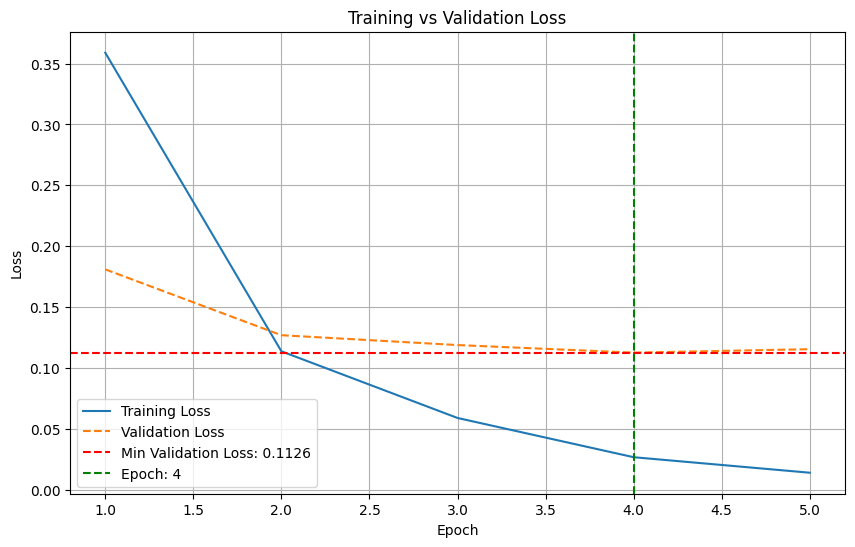

Macro-Averaged F1 Score: 0.5732

Micro-Averaged F1 Score: 0.7027

Weigthed-Averaged F1 Score: 0.7064

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1429     0.2222     7         

I-AND Gateway                       0.0000     0.0000     0.0000     4         

B-Activity                          0.8527     0.8527     0.8527     129       

I-Activity                          0.6667     0.3333     0.4444     6         

B-Activity Data                     0.8017     0.8087     0.8052     115       

I-Activity Data                     0.5252     0.7087     0.6033     103       

B-Actor                             0.8817     0.8039     0.8410     102       

I-Actor                             0.7727     0.8293     0.8000     82        

B-Condition Specification           0.9091     0.4167     0.5714     24        

I-Condition Specification           0.2857     0.3810     0.3265     21        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.6485, Precision: 0.8390, Recall: 0.8849, F1: 0.8599
Step 50, Loss: 0.1819, Precision: 0.9155, Recall: 0.9277, F1: 0.9162
Average training loss: 0.5067

Macro-Averaged F1 Score: 0.2208

Micro-Averaged F1 Score: 0.4261

Weigthed-Averaged F1 Score: 0.4217

Epoch 2/5
Training...
Step 0, Loss: 0.2188, Precision: 0.9135, Recall: 0.9269, F1: 0.9144
Step 50, Loss: 0.1635, Precision: 0.9532, Recall: 0.9543, F1: 0.9494
Average training loss: 0.1814

Macro-Averaged F1 Score: 0.2958

Micro-Averaged F1 Score: 0.5879

Weigthed-Averaged F1 Score: 0.5807

Epoch 3/5
Training...
Step 0, Loss: 0.2234, Precision: 0.9534, Recall: 0.9547, F1: 0.9498
Step 50, Loss: 0.0953, Precision: 0.9578, Recall: 0.9625, F1: 0.9581
Average training loss: 0.1401

Macro-Averaged F1 Score: 0.3261

Micro-Averaged F1 Score: 0.6336

Weigthed-Averaged F1 Score: 0.6231

Epoch 4/5
Training...
Step 0, Loss: 0.1391, Precision: 0.9582, Recall: 0.9628, F1: 0.9585
Step 50, Loss: 0.0952, Precision: 

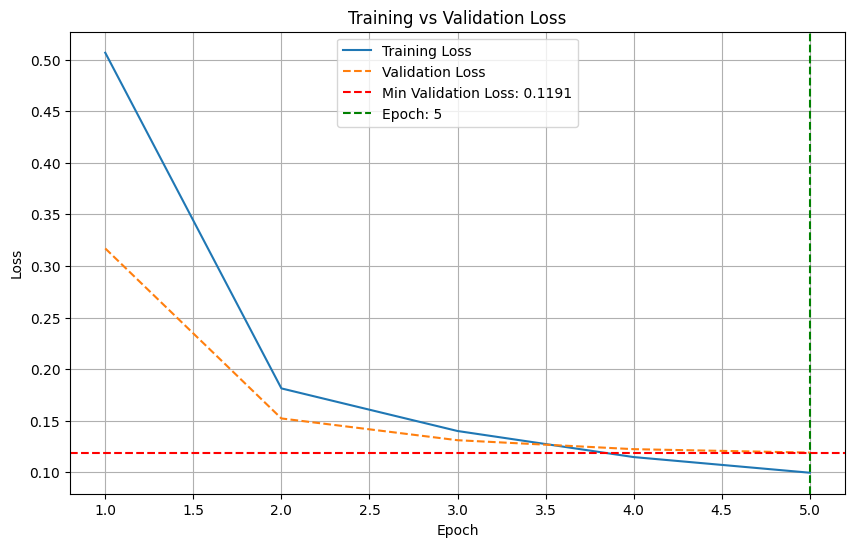

Macro-Averaged F1 Score: 0.3364

Micro-Averaged F1 Score: 0.6623

Weigthed-Averaged F1 Score: 0.6498

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7134     0.9180     0.8029     122       

I-Activity                          0.0000     0.0000     0.0000     7         

B-Activity Data                     0.5906     0.6522     0.6198     115       

I-Activity Data                     0.3195     0.5567     0.4060     97        

B-Actor                             0.8163     0.9677     0.8856     124       

I-Actor                             0.7879     0.9455     0.8595     110       

B-Condition Specification           0.0000     0.0000     0.0000     18        

I-Condition Specification           0.1333     0.2222     0.1667     18        

B-Furth

In [ ]:
epoch_best = 5 #TODO

learning_rate = 4e-05
best_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, epoch_best, label_map, learning_rate)


To train on the (whole) dataset, save the model and download it for later use without having to retrain the model. Uncomment for it to work.

#3. Model Saving for Pipeline

First we need to create a subset of the data to keep separate documents for testing. These documents are then also removed from the original training data before it goes through training.

##3.1.1 Remove 6 documents for testing


In [ ]:
#@title Training Model
def train_model_pipeline(input_data_pipeline, BATCH_SIZE, EPOCHS, label_map, learning_rate):
  # Training of the model
  # Instantiate the dataset and dataloader for validation
  train_data, val_data = train_test_split(input_data_pipeline, test_size=0.2, random_state=SEED)

  train_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in train_data],
      labels=[entry['ner-tags'] for entry in train_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )
  # Instantiate the dataset and dataloader for validation
  val_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in val_data],
      labels=[entry['ner-tags'] for entry in val_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  #loading the desired model: each fold we need start fresh
  model = BertForTokenClassification.from_pretrained("bert-large-cased", num_labels=NUM_LABELS)

  # Fine-tuning setup, can be changed for model optimisation
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  total_steps = len(train_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Using funtion defined above to train the model and obtain the losses for plotting at the same time
  model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map)
  plot_losses(training_losses,validation_losses)

  #Evaluating the model in this fold
  val_metrics = evaluate_model(model, val_loader, label_map)

  #So it is printed pretty :)
  header = "{:<35} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1")
  row_format = "{:<35} {:<10} {:<10} {:<10}\n"
  print(header)
  for label, metrics in val_metrics['detailed_metrics'].items():
    print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1'])))

  # Now, label_f1_scores[label] holds a list of F1 scores for that label across all folds
  return model

Based on the testing on proper learning rates and looking at the loss graphs we set the epochs to 5 and the lr to ```5e-05```.

{'doc-8.2', 'doc-3.1', 'doc-10.12', 'doc-10.7', 'doc-9.3', 'doc-20.5 - edit pictures'}
data loaded


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training...
Step 0, Loss: 2.6986, Precision: 0.8320, Recall: 0.8621, F1: 0.8466
Step 47, Loss: 0.1366, Precision: 0.9263, Recall: 0.9437, F1: 0.9321
Average training loss: 0.3759

Macro-Averaged F1 Score: 0.2188

Micro-Averaged F1 Score: 0.4549

Weigthed-Averaged F1 Score: 0.4365

Epoch 2/5
Training...
Step 0, Loss: 0.2519, Precision: 0.9284, Recall: 0.9447, F1: 0.9339
Step 47, Loss: 0.0597, Precision: 0.9550, Recall: 0.9616, F1: 0.9563
Average training loss: 0.1377

Macro-Averaged F1 Score: 0.3415

Micro-Averaged F1 Score: 0.6200

Weigthed-Averaged F1 Score: 0.6082

Epoch 3/5
Training...
Step 0, Loss: 0.1444, Precision: 0.9556, Recall: 0.9620, F1: 0.9568
Step 47, Loss: 0.1222, Precision: 0.9636, Recall: 0.9661, F1: 0.9638
Average training loss: 0.0768

Macro-Averaged F1 Score: 0.4783

Micro-Averaged F1 Score: 0.6716

Weigthed-Averaged F1 Score: 0.6742

Epoch 4/5
Training...
Step 0, Loss: 0.0594, Precision: 0.9640, Recall: 0.9659, F1: 0.9637
Step 47, Loss: 0.0289, Precision: 

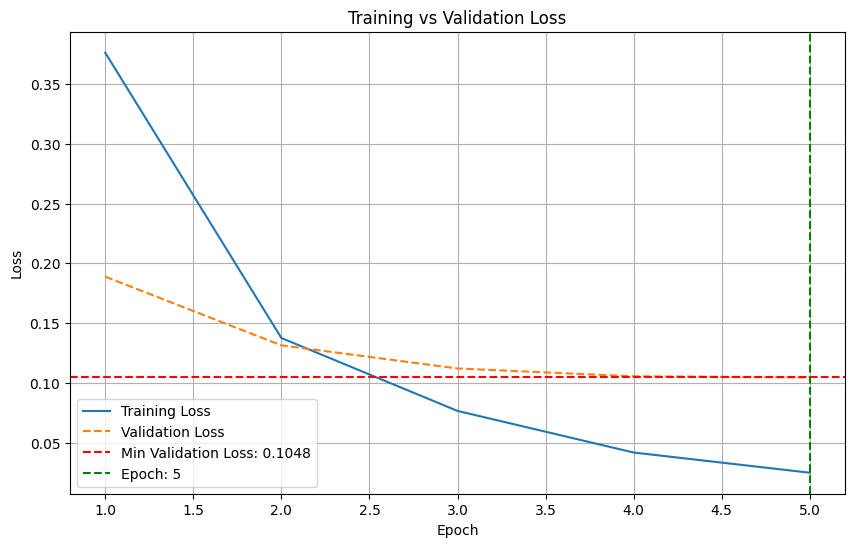

Macro-Averaged F1 Score: 0.5640

Micro-Averaged F1 Score: 0.7056

Weigthed-Averaged F1 Score: 0.7094

Label                               Precision  Recall     F1        

B-XOR Gateway                       0.9615     0.8065     0.8772    

I-Further Specification             0.1154     0.2000     0.1463    

I-XOR Gateway                       0.6667     0.5000     0.5714    

B-Further Specification             0.5000     0.3333     0.4000    

O                                   0.5974     0.7395     0.6609    

B-Activity                          0.8240     0.9035     0.8619    

B-AND Gateway                       0.0000     0.0000     0.0000    

B-Activity Data                     0.7719     0.8224     0.7964    

B-Actor                             0.8673     0.8500     0.8586    

I-AND Gateway                       0.0000     0.0000     0.0000    

B-Condition Specification           0.8235     0.6667     0.7368    

I-Activity                          1.0000     0.5000     

In [ ]:
def pick_and_remove_documents(data, num_docs, SEED):
    # Pick 6 documents at random
    random.seed(SEED)
    selected_docs_indices = random.sample(range(len(data)), num_docs)
    selected_docs = [data[i] for i in selected_docs_indices]

    # Remove the selected documents from the original data
    remaining_docs = [doc for i, doc in enumerate(data) if i not in selected_docs_indices]

    return selected_docs, remaining_docs

try:

  selected_docs, remaining_docs = pick_and_remove_documents(unflattened_data, 6, SEED)
  folder_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/NER_TESTING/'

  check= set()
  for document in selected_docs:
    for sentence in document:
      check.add(sentence['document name'])
  print(check)

  # here the selected documents are saved for pipeline testing
  for i, document in enumerate(selected_docs):
        file_path = os.path.join(folder_path, f'document_{i+1}.json')
        with open(file_path, 'w') as file:
            for sentence in document:
                # Convert the sentence to a JSON string and write it with a newline
                json_line = json.dumps(sentence) + '\n'
                file.write(json_line)

  input_data_pipeline = [item for group in remaining_docs for item in group]

  if input_data_pipeline:
    print('data loaded')

  #training of the model without the 6 left out documents
  epochs_pipe= 5 #TODO
  lr= 4e-05
  model2 = train_model_pipeline(input_data_pipeline, BATCH_SIZE, epochs_pipe, label_map, lr)

except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")

##3.2 Training and saving the model



In [ ]:
# Save the model to a file
# Assuming 'best_model' is your trained model and 'tokenizer' is your tokenizer
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/MODEL/"
tokenizer_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/TOKENIZER/"

# Save the model & tokenizer
model2.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/TOKENIZER/tokenizer_config.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/TOKENIZER/special_tokens_map.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/TOKENIZER/vocab.txt',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_large_cased/6DOCLEFTOUT/TOKENIZER/added_tokens.json')